In [1]:
import fceulib
import ppu_dump
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# rom = "mario.nes"
# movie = "mario.fm2"
# start_t = 373
# rom = "metroid.nes"
# movie = "metroid.fm2"
# start_t = 518+39
rom = "metroid.nes"
movie = "metroid-long.fm2"
start_t = 560
# rom = "smb2u.nes"
# movie = "smb2u.fm2"
# start_t = 600
emu = fceulib.runGame(rom)
inputs = fceulib.readInputs(movie)
for i in inputs[:start_t]:
    emu.stepFull(i, 0x0)

NTS:
3 2 
1 0
M 1 base 3
T: 0


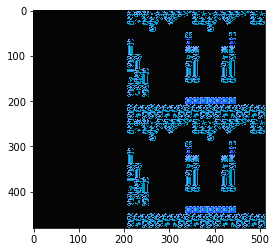

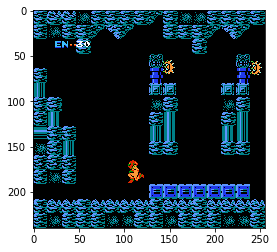

Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.105501808226 0.963213384151 (19, 23) (6, 8)
Sc1 Offset: -2 0 -2 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 25 0
25 0 26 0 (-1, 0)
Match1 0.104176871479 0.973858118057 (18, 23) (7, 8)
Sc1 Offset: -1 0 -3 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 25 0
25 0 25 0 (0, 0)
Match1 0.105652689934 0.963273227215 (17, 23) (6, 8)
Sc1 Offset: -2 0 -5 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 25 0
25 0 25 0 (0, 0)
Match1 0.105304017663 0.971168935299 (20, 23) (7, 8)
Sc1 Offset: -1 0 -6 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 25 0
25 0 25 0 (0, 0)
Match1 0.105603575706 0.962980091572 (19, 23) (6, 8)
Sc1 Offset: -2 0 -8 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 25 0
25 0 25 0 (0, 0)
Match1 0.106468625367 0.973621308804 (19, 23) (7, 8)
Sc1 Offset: -1 0 -9 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 24 0
24 0 25 0 (-1, 0)
Match1 0.109460279346 0.961516618729 (19, 23) (6, 8)
Sc1 Offset: -2 0 -11 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 24 0
24 0 24 0 (0, 0)
Match1 0.112167678773 0.972560942173 (19, 23) (7, 8)
Sc1 Offset: -1 0 -12 0
NTS:


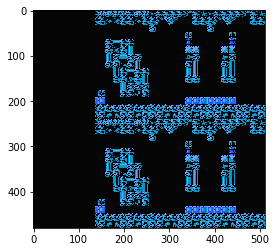

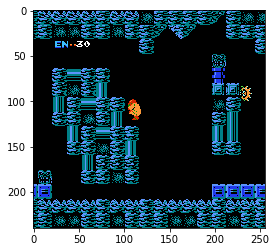

Sc2: 17 0
17 0 17 30 (0, 0)
Match1 0.101242594421 0.976377189159 (18, 23) (7, 8)
Sc1 Offset: -1 0 -70 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 17 0
17 0 17 0 (0, 0)
Match1 0.102334402502 0.972667217255 (18, 23) (7, 8)
Sc1 Offset: -1 0 -71 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 17 30
17 30 17 0 (0, 0)
Match1 0.102843940258 0.977551817894 (18, 23) (7, 8)
Sc1 Offset: -1 0 -72 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 17 0
17 0 17 30 (0, 0)
Match1 0.102711670101 0.978371560574 (18, 23) (7, 8)
Sc1 Offset: -1 0 -73 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 30
16 30 17 0 (-1, 0)
Match1 0.103755794466 0.982623040676 (18, 23) (7, 8)
Sc1 Offset: -1 0 -74 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 0
16 0 16 30 (0, 0)
Match1 0.105279833078 0.966683447361 (17, 23) (6, 8)
Sc1 Offset: -2 0 -76 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 0
16 0 16 0 (0, 0)
Match1 0.100818969309 0.996685147285 (0, 24) (8, 8)
Sc1 Offset: 0 0 -76 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 0
16 0 16 0 (0, 0)
Match1 0.100500844419 0.990238726139 (0, 24) (8, 8)
Sc1 Offset: 0 0 -76

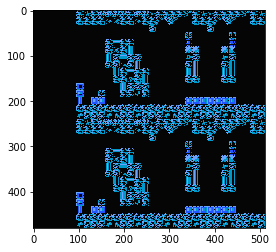

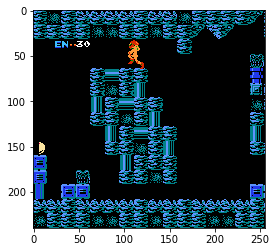

Sc2: 12 30
12 30 12 0 (0, 0)
Match1 0.122495986521 0.963229179382 (22, 22) (6, 8)
Sc1 Offset: -2 0 -113 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 12 30 (-1, 0)
Match1 0.122595064342 0.972302854061 (23, 22) (7, 8)
Sc1 Offset: -1 0 -114 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.125419288874 0.963724911213 (22, 22) (6, 8)
Sc1 Offset: -2 0 -116 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.126195728779 0.971279978752 (23, 22) (7, 8)
Sc1 Offset: -1 0 -117 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.126928701997 0.96171271801 (22, 22) (6, 8)
Sc1 Offset: -2 0 -119 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.124878704548 0.97926402092 (23, 22) (7, 8)
Sc1 Offset: -1 0 -120 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.128471031785 0.967970073223 (22, 22) (6, 8)
Sc1 Offset: -2 0 -122 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 10 30
10 30 11 0 (-1, 0)
Match1 0.128476589918 0.975208640099 (23, 22) (7, 8)
Sc1 Offset: 

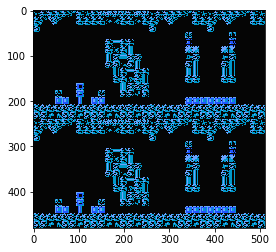

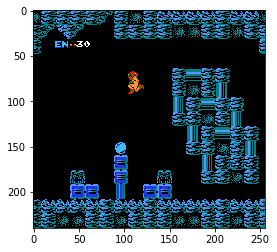

Sc2: 0 0
0 0 1 0 (-1, 0)
Match1 0.135519251227 0.965533673763 (22, 22) (6, 8)
Sc1 Offset: -2 0 -203 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.136050343513 0.975398421288 (23, 22) (7, 8)
Sc1 Offset: -1 0 -204 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 30
0 30 0 0 (0, 0)
Match1 0.137681677938 0.96529597044 (22, 22) (6, 8)
Sc1 Offset: -2 0 -206 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 30 (0, 0)
Match1 0.139121726155 0.974043905735 (23, 22) (7, 8)
Sc1 Offset: -1 0 -207 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.139749512076 0.999999940395 (24, 22) (8, 8)
Sc1 Offset: 0 0 -207 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.139749512076 0.999999940395 (24, 22) (8, 8)
Sc1 Offset: 0 0 -207 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.139749512076 0.999999940395 (24, 22) (8, 8)
Sc1 Offset: 0 0 -207 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.140802562237 0.965083479881 (22, 22) (6, 8)
Sc1 Offset: -2 0 -209 0
NTS:
0 1 
2 3
M 1

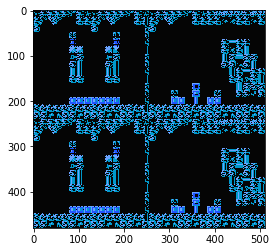

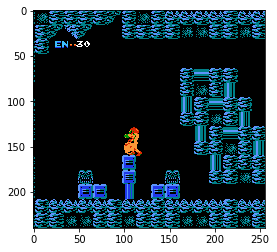

Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 

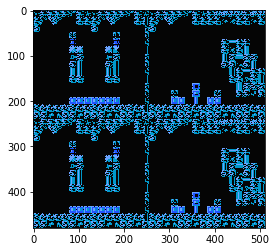

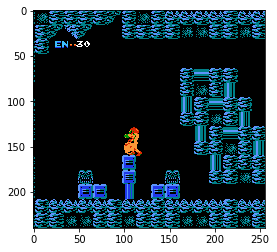

Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 

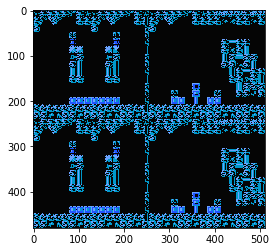

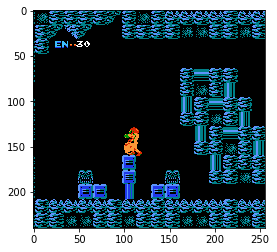

Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 

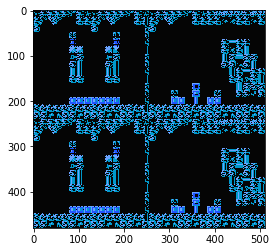

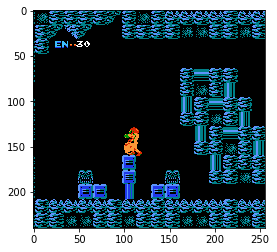

Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14367480576 1.0 (24, 22) (8, 8)
Sc1 

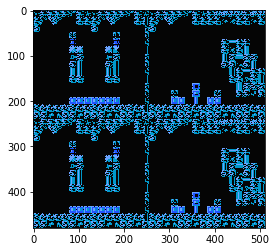

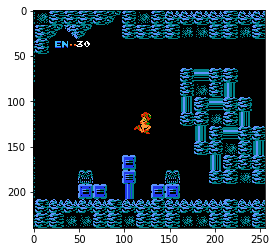

Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.148516610265 0.98695987463 (0, 24) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.148308351636 0.987630665302 (0, 24) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.149233698845 0.987305283546 (0, 24) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.146895751357 0.989170968533 (0, 24) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.148058623075 0.990624010563 (0, 24) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.143961817026 0.989683151245 (0, 24) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.144135579467 0.994273126125 (0, 24) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.14356726408 0.98980653286 (0, 24) (8, 8)
Sc1 Offset: 0 0 -210 0
NTS:
0 1 
2 

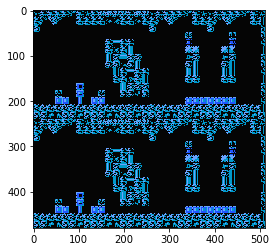

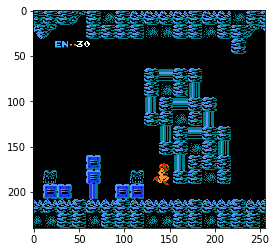

Sc2: 4 0
4 0 4 0 (0, 0)
Match1 0.123241856694 0.977987706661 (0, 22) (9, 8)
Sc1 Offset: 1 0 -170 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 4 0
4 0 4 0 (0, 0)
Match1 0.12079384923 0.966523528099 (0, 22) (10, 8)
Sc1 Offset: 2 0 -168 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 5 30
5 30 4 0 (1, 0)
Match1 0.128650844097 0.977916181087 (0, 22) (9, 8)
Sc1 Offset: 1 0 -167 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 5 0
5 0 5 30 (0, 0)
Match1 0.125603213906 0.965775847435 (0, 22) (10, 8)
Sc1 Offset: 2 0 -165 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 5 0
5 0 5 0 (0, 0)
Match1 0.13414812088 0.980069696903 (0, 22) (9, 8)
Sc1 Offset: 1 0 -164 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 5 0
5 0 5 0 (0, 0)
Match1 0.133873894811 0.97698867321 (0, 22) (9, 8)
Sc1 Offset: 1 0 -163 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 5 0
5 0 5 0 (0, 0)
Match1 0.136373013258 0.99102550745 (20, 18) (8, 8)
Sc1 Offset: 0 0 -163 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 5 0
5 0 5 0 (0, 0)
Match1 0.13514919579 1.0 (20, 18) (8, 8)
Sc1 Offset: 0 0 -163 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 5 0
5 0 5 0 

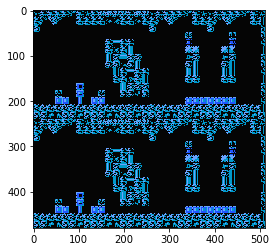

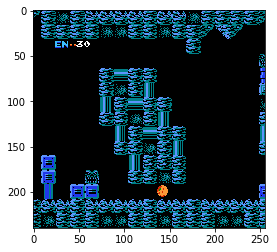

Sc2: 10 0
10 0 10 0 (0, 0)
Match1 0.129409357905 0.972609519958 (0, 22) (10, 8)
Sc1 Offset: 2 0 -119 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 30
11 30 10 0 (1, 0)
Match1 0.134521454573 0.984769463539 (1, 24) (9, 8)
Sc1 Offset: 1 0 -118 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 11 30 (0, 0)
Match1 0.133561998606 0.972227632999 (0, 22) (10, 8)
Sc1 Offset: 2 0 -116 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 30
11 30 11 0 (0, 0)
Match1 0.136548757553 0.98344451189 (20, 23) (9, 8)
Sc1 Offset: 1 0 -115 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 11 30 (0, 0)
Match1 0.132080003619 0.971792280674 (21, 23) (10, 8)
Sc1 Offset: 2 0 -113 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.129973724484 0.983506023884 (20, 23) (9, 8)
Sc1 Offset: 1 0 -112 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 12 0
12 0 11 0 (1, 0)
Match1 0.127768680453 0.971823811531 (21, 23) (10, 8)
Sc1 Offset: 2 0 -110 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 12 0
12 0 12 0 (0, 0)
Match1 0.129534542561 0.983359158039 (20, 23) (9, 8)
Sc1 Offset: 1 0 -1

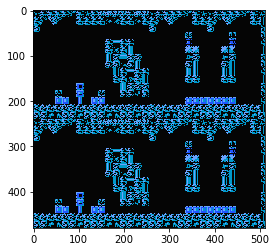

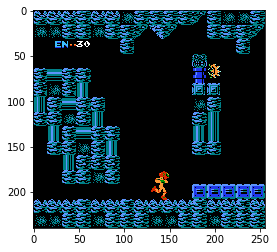

Sc2: 20 0
20 0 19 0 (1, 0)
Match1 0.103833116591 0.954504430294 (0, 22) (10, 8)
Sc1 Offset: 2 0 -46 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 20 0
20 0 20 0 (0, 0)
Match1 0.107930310071 0.97297924757 (0, 22) (9, 8)
Sc1 Offset: 1 0 -45 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 20 0
20 0 20 0 (0, 0)
Match1 0.106523834169 0.960063576698 (0, 22) (10, 8)
Sc1 Offset: 2 0 -43 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 20 0
20 0 20 0 (0, 0)
Match1 0.110818579793 0.968826293945 (0, 22) (9, 8)
Sc1 Offset: 1 0 -42 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 20 0
20 0 20 0 (0, 0)
Match1 0.108497068286 0.957458555698 (0, 22) (10, 8)
Sc1 Offset: 2 0 -40 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 21 0
21 0 20 0 (1, 0)
Match1 0.111250467598 0.972080647945 (0, 22) (9, 8)
Sc1 Offset: 1 0 -39 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.111718334258 0.955310046673 (0, 22) (10, 8)
Sc1 Offset: 2 0 -37 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 21 30
21 30 21 0 (0, 0)
Match1 0.115738816559 0.970940232277 (0, 22) (9, 8)
Sc1 Offset: 1 0 -36 0
NTS:
3 2 
1 

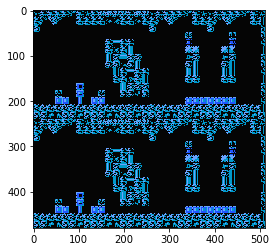

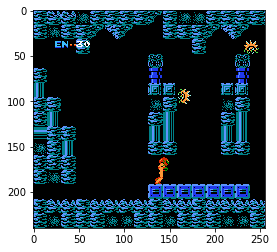

Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.110977865756 0.9565731287 (23, 23) (10, 8)
Sc1 Offset: 2 0 3 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.110217265785 0.969546496868 (20, 23) (9, 8)
Sc1 Offset: 1 0 4 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.111748963594 0.952192187309 (21, 23) (10, 8)
Sc1 Offset: 2 0 6 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.111488357186 0.969617486 (22, 23) (9, 8)
Sc1 Offset: 1 0 7 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 26 30
26 30 26 0 (0, 0)
Match1 0.11435277015 0.94898378849 (21, 23) (10, 8)
Sc1 Offset: 2 0 9 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 27 0
27 0 26 30 (1, 0)
Match1 0.114365063608 0.971555650234 (22, 23) (9, 8)
Sc1 Offset: 1 0 10 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 27 30
27 30 27 0 (0, 0)
Match1 0.115488745272 0.948707163334 (21, 23) (10, 8)
Sc1 Offset: 2 0 12 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 27 0
27 0 27 30 (0, 0)
Match1 0.113088130951 0.956348776817 (22, 23) (9, 8)
Sc1 Offset: 1 0 13 0
NTS:
3 2 
1 0
M 1 b

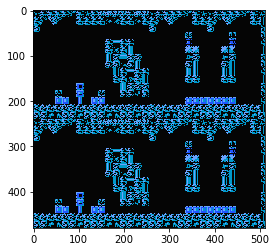

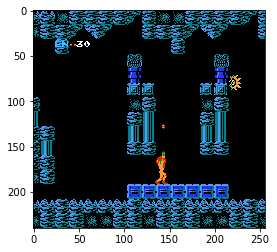

Sc2: 29 30
29 30 29 0 (0, 0)
Match1 0.115916095674 0.988574981689 (21, 23) (8, 8)
Sc1 Offset: 0 0 24 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 29 0
29 0 29 30 (0, 0)
Match1 0.116159446537 0.988574981689 (21, 23) (8, 8)
Sc1 Offset: 0 0 24 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 29 0
29 0 29 0 (0, 0)
Match1 0.116792276502 0.993432700634 (21, 23) (8, 8)
Sc1 Offset: 0 0 24 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 29 0
29 0 29 0 (0, 0)
Match1 0.116043575108 0.998439490795 (21, 23) (8, 8)
Sc1 Offset: 0 0 24 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 29 0
29 0 29 0 (0, 0)
Match1 0.116515658796 0.98927885294 (21, 23) (8, 8)
Sc1 Offset: 0 0 24 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 29 30
29 30 29 0 (0, 0)
Match1 0.117004521191 0.989220201969 (21, 23) (8, 8)
Sc1 Offset: 0 0 24 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 29 0
29 0 29 30 (0, 0)
Match1 0.116948060691 0.978978097439 (21, 23) (8, 8)
Sc1 Offset: 0 0 24 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 29 0
29 0 29 0 (0, 0)
Match1 0.116400390863 0.972424209118 (22, 23) (9, 8)
Sc1 Offset: 1 0 25 0
NTS:
3 2 
1 

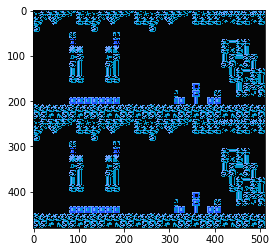

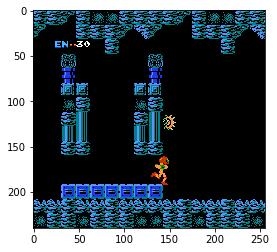

Sc2: 6 0
6 0 6 0 (0, 0)
Match1 0.122008085251 0.947508335114 (23, 23) (10, 8)
Sc1 Offset: 2 0 99 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 6 30
6 30 6 0 (0, 0)
Match1 0.124141067266 0.968817055225 (22, 23) (9, 8)
Sc1 Offset: 1 0 100 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 6 0
6 0 6 30 (0, 0)
Match1 0.123966597021 0.984696209431 (19, 23) (8, 8)
Sc1 Offset: 0 0 100 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 6 0
6 0 6 0 (0, 0)
Match1 0.124074950814 0.989614725113 (19, 23) (8, 8)
Sc1 Offset: 0 0 100 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 6 0
6 0 6 0 (0, 0)
Match1 0.124208875 0.993246495724 (19, 23) (8, 8)
Sc1 Offset: 0 0 100 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 6 0
6 0 6 0 (0, 0)
Match1 0.124064207077 0.988590240479 (19, 23) (8, 8)
Sc1 Offset: 0 0 100 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 6 0
6 0 6 0 (0, 0)
Match1 0.12395324558 0.988740563393 (19, 23) (8, 8)
Sc1 Offset: 0 0 100 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 6 30
6 30 6 0 (0, 0)
Match1 0.124292783439 0.987053096294 (19, 23) (8, 8)
Sc1 Offset: 0 0 100 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 6 

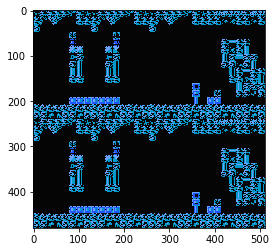

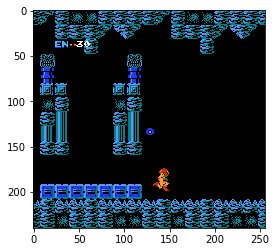

Sc2: 9 0
9 0 8 0 (1, 0)
Match1 0.147646740079 0.961122691631 (21, 23) (10, 8)
Sc1 Offset: 2 0 122 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 9 0
9 0 9 0 (0, 0)
Match1 0.149500772357 0.978270351887 (20, 23) (9, 8)
Sc1 Offset: 1 0 123 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 9 0
9 0 9 0 (0, 0)
Match1 0.150561958551 0.962120652199 (23, 23) (10, 8)
Sc1 Offset: 2 0 125 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 9 0
9 0 9 0 (0, 0)
Match1 0.150564417243 0.973603963852 (23, 23) (9, 8)
Sc1 Offset: 1 0 126 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 9 0
9 0 9 0 (0, 0)
Match1 0.148224636912 0.962233185768 (23, 23) (10, 8)
Sc1 Offset: 2 0 128 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 10 0
10 0 9 0 (1, 0)
Match1 0.147467106581 0.978712141514 (22, 23) (9, 8)
Sc1 Offset: 1 0 129 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 10 0
10 0 10 0 (0, 0)
Match1 0.147701337934 0.958502590656 (23, 23) (10, 8)
Sc1 Offset: 2 0 131 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 10 0
10 0 10 0 (0, 0)
Match1 0.147153317928 0.976077795029 (22, 23) (9, 8)
Sc1 Offset: 1 0 132 0
NTS:
0 1 
2 3
M 1 bas

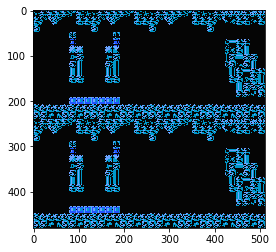

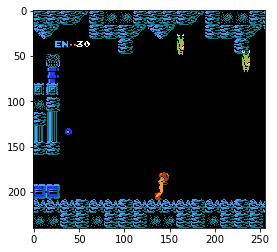

Sc2: 20 0
20 0 20 0 (0, 0)
Match1 0.153308272362 0.917279779911 (21, 23) (10, 8)
Sc1 Offset: 2 0 212 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 20 0
20 0 20 0 (0, 0)
Match1 0.149149388075 0.936059176922 (20, 23) (9, 8)
Sc1 Offset: 1 0 213 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 20 0
20 0 20 0 (0, 0)
Match1 0.147108435631 0.908737123013 (21, 23) (10, 8)
Sc1 Offset: 2 0 215 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 20 0
20 0 20 0 (0, 0)
Match1 0.150040462613 0.916921555996 (20, 23) (9, 8)
Sc1 Offset: 1 0 216 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 20 0 (1, 0)
Match1 0.145253285766 0.90372300148 (21, 23) (10, 8)
Sc1 Offset: 2 0 218 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.146360144019 0.932865262032 (20, 23) (9, 8)
Sc1 Offset: 1 0 219 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.143575429916 0.902118086815 (21, 23) (10, 8)
Sc1 Offset: 2 0 221 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.147680446506 0.928591310978 (20, 23) (9, 8)
Sc1 Offset: 1 0 222 0
NTS:
0

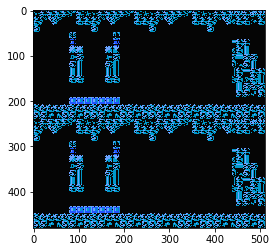

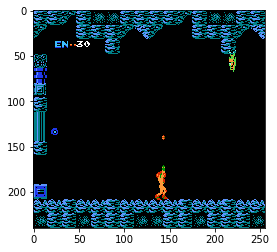

Sc2: 22 0
22 0 22 30 (0, 0)
Match1 0.155374377966 0.990832090378 (19, 23) (8, 8)
Sc1 Offset: 0 0 224 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 0
22 0 22 0 (0, 0)
Match1 0.155378445983 0.936728000641 (20, 23) (9, 8)
Sc1 Offset: 1 0 225 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 30
22 30 22 0 (0, 0)
Match1 0.157576113939 0.939269900322 (20, 23) (9, 8)
Sc1 Offset: 1 0 226 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 0
22 0 22 30 (0, 0)
Match1 0.161578461528 0.965046525002 (1, 24) (9, 8)
Sc1 Offset: 1 0 227 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 0
22 0 22 0 (0, 0)
Match1 0.16058383882 0.95134049654 (1, 24) (9, 8)
Sc1 Offset: 1 0 228 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 0
22 0 22 0 (0, 0)
Match1 0.156604781747 0.963843405247 (1, 24) (9, 8)
Sc1 Offset: 1 0 229 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 0
22 0 22 0 (0, 0)
Match1 0.156681865454 0.909646034241 (2, 24) (10, 8)
Sc1 Offset: 2 0 231 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 0
22 0 22 0 (0, 0)
Match1 0.154105708003 0.929065525532 (1, 24) (9, 8)
Sc1 Offset: 1 0 232 0
NTS:
0 1 
2

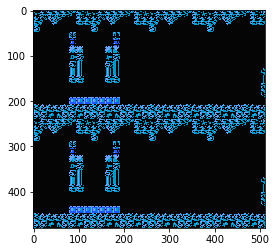

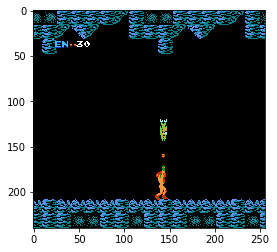

Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.148774176836 0.973806858063 (19, 23) (8, 8)
Sc1 Offset: 0 0 294 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.148774176836 0.997209191322 (19, 23) (8, 8)
Sc1 Offset: 0 0 294 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.146845430136 0.966972470284 (19, 23) (8, 8)
Sc1 Offset: 0 0 294 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.145935043693 0.99862575531 (19, 23) (8, 8)
Sc1 Offset: 0 0 294 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.149281874299 0.992207944393 (19, 23) (8, 8)
Sc1 Offset: 0 0 294 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.152927309275 0.997395932674 (19, 23) (8, 8)
Sc1 Offset: 0 0 294 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 30
30 30 30 0 (0, 0)
Match1 0.152930989861 0.997652828693 (19, 23) (8, 8)
Sc1 Offset: 0 0 294 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 30 (0, 0)
Match1 0.152775391936 0.997222602367 (19, 23) (8, 8)
Sc1 Offset: 0 0 294 0
NTS:
0 

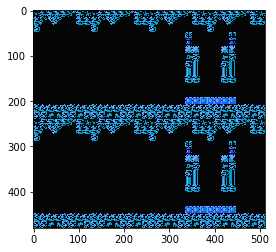

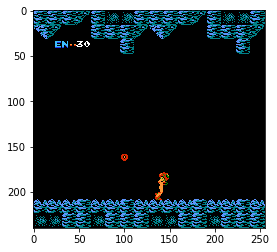

Sc2: 4 0
4 0 3 30 (1, 0)
Match1 0.158115342259 0.929268419743 (18, 24) (10, 8)
Sc1 Offset: 2 0 338 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 4 0
4 0 4 0 (0, 0)
Match1 0.156232431531 0.95196211338 (17, 24) (9, 8)
Sc1 Offset: 1 0 339 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 4 30
4 30 4 0 (0, 0)
Match1 0.157486349344 0.92626708746 (18, 24) (10, 8)
Sc1 Offset: 2 0 341 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 4 0
4 0 4 30 (0, 0)
Match1 0.160288840532 0.958922863007 (17, 24) (9, 8)
Sc1 Offset: 1 0 342 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 4 0
4 0 4 0 (0, 0)
Match1 0.157517239451 0.920564115047 (18, 24) (10, 8)
Sc1 Offset: 2 0 344 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 5 30
5 30 4 0 (1, 0)
Match1 0.157549932599 0.957657516003 (17, 24) (9, 8)
Sc1 Offset: 1 0 345 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 5 30
5 30 5 30 (0, 0)
Match1 0.155398204923 0.922361254692 (18, 24) (10, 8)
Sc1 Offset: 2 0 347 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 5 0
5 0 5 30 (0, 0)
Match1 0.153021946549 0.943123877048 (17, 24) (9, 8)
Sc1 Offset: 1 0 348 0
NTS:
3 2 
1 0
M 1 bas

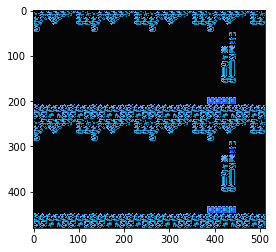

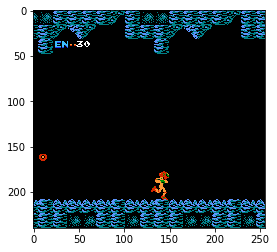

Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.164247006178 0.924242734909 (18, 24) (10, 8)
Sc1 Offset: 2 0 428 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.161890774965 0.943825602531 (17, 24) (9, 8)
Sc1 Offset: 1 0 429 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 30
15 30 15 0 (0, 0)
Match1 0.166253790259 0.933234632015 (18, 24) (10, 8)
Sc1 Offset: 2 0 431 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 30 (0, 0)
Match1 0.165386646986 0.962131440639 (17, 24) (9, 8)
Sc1 Offset: 1 0 432 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 30
16 30 15 0 (1, 0)
Match1 0.163510352373 0.931289970875 (18, 24) (10, 8)
Sc1 Offset: 2 0 434 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 0
16 0 16 30 (0, 0)
Match1 0.163513422012 0.960641860962 (17, 24) (9, 8)
Sc1 Offset: 1 0 435 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 0
16 0 16 0 (0, 0)
Match1 0.160447344184 0.926980376244 (18, 24) (10, 8)
Sc1 Offset: 2 0 437 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 30
16 30 16 0 (0, 0)
Match1 0.158771693707 0.962469637394 (17, 24) (9, 8)
Sc1 Offset: 1 0 438

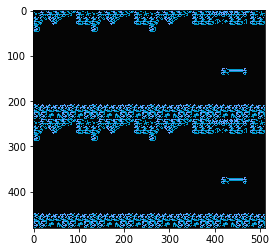

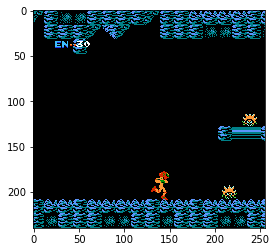

Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.153668090701 0.905566513538 (18, 24) (10, 8)
Sc1 Offset: 2 0 518 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.155092194676 0.961420714855 (17, 24) (9, 8)
Sc1 Offset: 1 0 519 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.152042508125 0.913073956966 (18, 24) (10, 8)
Sc1 Offset: 2 0 521 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 27 30
27 30 26 0 (1, 0)
Match1 0.149641111493 0.956773519516 (17, 24) (9, 8)
Sc1 Offset: 1 0 522 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 27 0
27 0 27 30 (0, 0)
Match1 0.148875787854 0.920679569244 (18, 24) (10, 8)
Sc1 Offset: 2 0 524 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 27 30
27 30 27 0 (0, 0)
Match1 0.151717692614 0.9517750144 (17, 24) (9, 8)
Sc1 Offset: 1 0 525 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 27 0
27 0 27 30 (0, 0)
Match1 0.155719354749 0.912263453007 (18, 24) (10, 8)
Sc1 Offset: 2 0 527 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 27 0
27 0 27 0 (0, 0)
Match1 0.152251377702 0.943202853203 (20, 23) (9, 8)
Sc1 Offset: 1 0 528 0
N

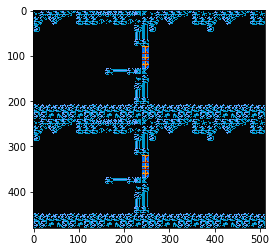

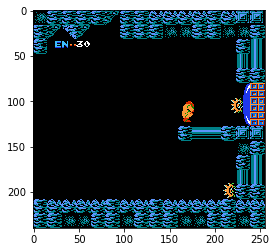

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.150724560022 0.970918238163 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.150351420045 0.972163677216 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.15025472641 0.973988592625 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.14856852591 0.965147972107 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.15063534677 0.958785712719 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.150598466396 0.955682635307 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.149217143655 0.954803884029 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.146419718862 0.962765514851 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0

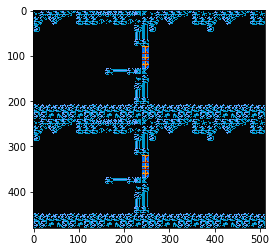

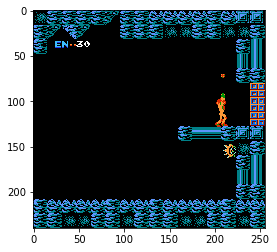

Sc2: 0 0
0 0 0 30 (0, 0)
Match1 0.133440464735 0.957169115543 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.132879048586 0.989303052425 (16, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 30
0 30 0 0 (0, 0)
Match1 0.134707376361 0.982553184032 (16, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 30
0 30 0 30 (0, 0)
Match1 0.134187504649 0.953224539757 (16, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 30 (0, 0)
Match1 0.136555358768 0.995473086834 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 30
0 30 0 0 (0, 0)
Match1 0.136686980724 0.995437562466 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 30 (0, 0)
Match1 0.13607147336 0.986996173859 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.135776758194 0.983295440674 (0, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2:

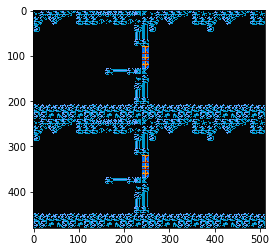

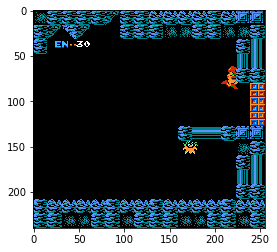

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.129438072443 0.98008441925 (16, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.130000546575 0.98507219553 (16, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.129837468266 0.974927186966 (16, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.130156636238 0.968439817429 (16, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 30
0 30 0 0 (0, 0)
Match1 0.129460155964 0.974592149258 (16, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 30 (0, 0)
Match1 0.128660023212 0.97016787529 (16, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.128159746528 0.9763199687 (16, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.128060668707 0.969807267189 (16, 24) (8, 8)
Sc1 Offset: 0 0 560 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0

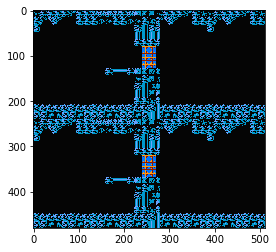

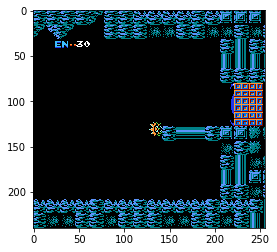

Sc2: 2 0
2 0 2 0 (0, 0)
Match1 0.163849815726 0.973448693752 (1, 22) (10, 8)
Sc1 Offset: 2 0 580 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 2 0
2 0 2 0 (0, 0)
Match1 0.168036743999 0.963010132313 (1, 22) (10, 8)
Sc1 Offset: 2 0 582 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 2 0
2 0 2 0 (0, 0)
Match1 0.167778819799 0.945276856422 (1, 22) (10, 8)
Sc1 Offset: 2 0 584 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 0
3 0 2 0 (1, 0)
Match1 0.179865196347 0.965185821056 (1, 22) (10, 8)
Sc1 Offset: 2 0 586 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 0
3 0 3 0 (0, 0)
Match1 0.180296242237 0.965561926365 (1, 22) (10, 8)
Sc1 Offset: 2 0 588 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 0
3 0 3 0 (0, 0)
Match1 0.182365074754 0.969517111778 (1, 22) (10, 8)
Sc1 Offset: 2 0 590 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 0
3 0 3 0 (0, 0)
Match1 0.182337716222 0.966088056564 (1, 22) (10, 8)
Sc1 Offset: 2 0 592 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 4 30
4 30 3 0 (1, 0)
Match1 0.183017760515 0.976712048054 (1, 22) (10, 8)
Sc1 Offset: 2 0 594 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 4

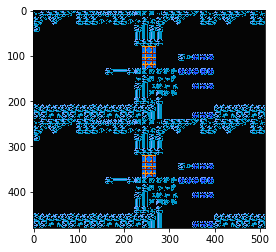

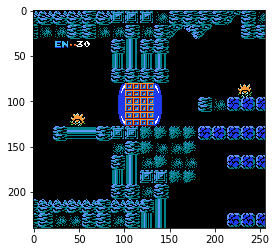

Sc2: 17 0
17 0 17 0 (0, 0)
Match1 0.0843396931887 0.971131384373 (22, 23) (10, 8)
Sc1 Offset: 2 0 700 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 17 0
17 0 17 0 (0, 0)
Match1 0.0829935446382 0.96631026268 (22, 23) (10, 8)
Sc1 Offset: 2 0 702 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 17 30
17 30 17 0 (0, 0)
Match1 0.0815522894263 0.961390316486 (22, 23) (10, 8)
Sc1 Offset: 2 0 704 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 18 30
18 30 17 30 (1, 0)
Match1 0.0768733844161 0.971306204796 (22, 23) (10, 8)
Sc1 Offset: 2 0 706 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 18 0
18 0 18 30 (0, 0)
Match1 0.0768774673343 0.966626703739 (22, 23) (10, 8)
Sc1 Offset: 2 0 708 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 18 30
18 30 18 0 (0, 0)
Match1 0.0744872540236 0.966749608517 (22, 23) (10, 8)
Sc1 Offset: 2 0 710 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 18 0
18 0 18 30 (0, 0)
Match1 0.0743039771914 0.96310788393 (22, 23) (10, 8)
Sc1 Offset: 2 0 712 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 19 0
19 0 18 0 (1, 0)
Match1 0.073748216033 0.97543245554 (22, 23) (10, 8)
Sc1 Offset

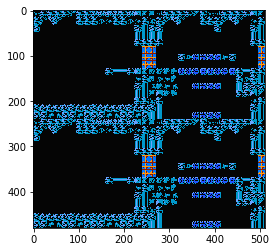

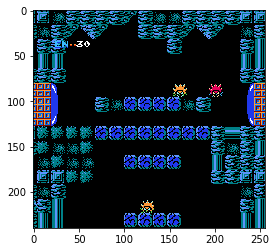

Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.0210542008281 0.960738003254 (22, 23) (10, 8)
Sc1 Offset: 2 0 814 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.0158207286149 0.961175441742 (22, 23) (10, 8)
Sc1 Offset: 2 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 31 0 (1, 0)
Match1 0.0138526931405 0.974396646023 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0139323417097 0.971350908279 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0152001995593 0.975596666336 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0148867527023 0.983908295631 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0144783463329 0.980919599533 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0148046864197 0.983818233013 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 

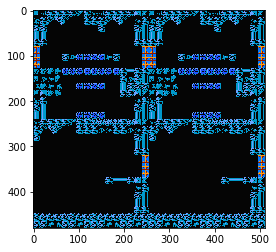

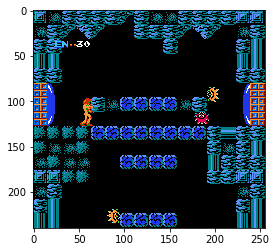

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.00921832676977 0.982313752174 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.00916504953057 0.990555465221 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0101162018254 0.983613848686 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.00952400639653 0.990515232086 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.00861068069935 0.981232106686 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.00899550877512 0.984527885914 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.00975987128913 0.978276014328 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.00826334860176 0.964018642902 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 

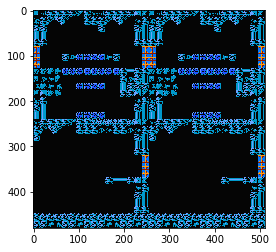

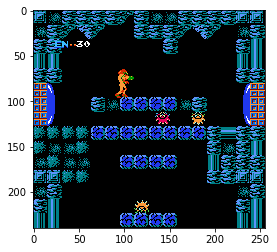

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0231863036752 0.974378108978 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0256990585476 0.973470211029 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0236769597977 0.974940001965 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0258237197995 0.960029423237 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0263289567083 0.967595994473 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0262031201273 0.973672032356 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0260742940009 0.970645368099 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0252257734537 0.967898726463 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3


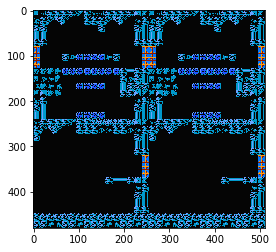

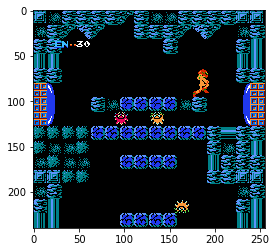

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0148750944063 0.96144258976 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0156852863729 0.966848552227 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0155222043395 0.9676181674 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0165826883167 0.966668784618 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0178499761969 0.970127522945 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0166946556419 0.974942088127 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.018066348508 0.964864730835 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0183746740222 0.961302220821 (24, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 0 base 3
Sc2:

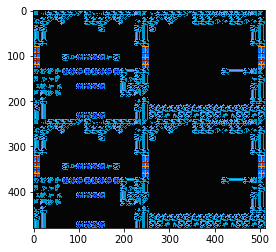

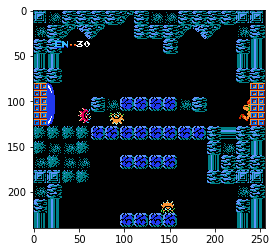

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0117901805788 0.976572811604 (20, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0112696923316 0.975813925266 (20, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0105080371723 0.972051084042 (20, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0107112471014 0.971408843994 (20, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0108150821179 0.973256349564 (20, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0102651622146 0.977729618549 (20, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 30
0 30 0 0 (0, 0)
Match1 0.0116902859882 0.973697245121 (20, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 30 (0, 0)
Match1 0.0124459918588 0.973954021931 (20, 23) (8, 8)
Sc1 Offset: 0 0 816 0
NTS:
3 2 
1 0
M 1 base

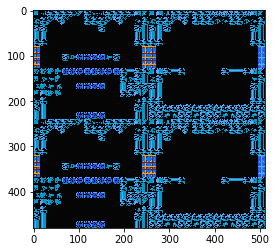

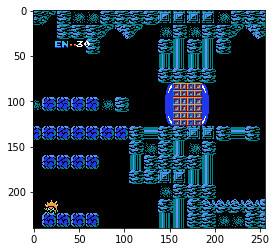

Sc2: 10 0
10 0 10 30 (0, 0)
Match1 0.0613578669727 0.984142303467 (1, 22) (10, 8)
Sc1 Offset: 2 0 904 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 10 0 (1, 0)
Match1 0.0605520866811 0.975337326527 (1, 22) (10, 8)
Sc1 Offset: 2 0 906 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.0619203150272 0.978553056717 (1, 22) (10, 8)
Sc1 Offset: 2 0 908 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.062108527869 0.979905068874 (1, 22) (10, 8)
Sc1 Offset: 2 0 910 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.0599174499512 0.98164087534 (1, 22) (10, 8)
Sc1 Offset: 2 0 912 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 12 0
12 0 11 0 (1, 0)
Match1 0.0641769394279 0.984306693077 (1, 22) (10, 8)
Sc1 Offset: 2 0 914 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 12 0
12 0 12 0 (0, 0)
Match1 0.0676976069808 0.983620345592 (1, 22) (10, 8)
Sc1 Offset: 2 0 916 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 12 30
12 30 12 0 (0, 0)
Match1 0.0694151967764 0.983016312122 (1, 22) (10, 8)
Sc1 Offset: 2 0 918 0


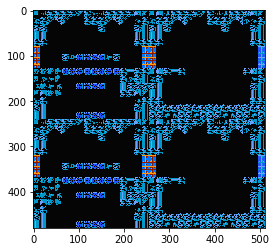

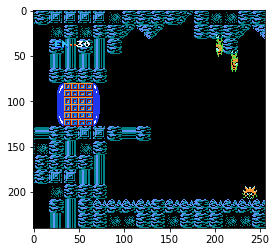

Sc2: 25 30
25 30 25 0 (0, 0)
Match1 0.186925292015 0.98141002655 (1, 22) (10, 8)
Sc1 Offset: 2 0 1024 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 26 0
26 0 25 30 (1, 0)
Match1 0.187656730413 0.979989588261 (1, 22) (10, 8)
Sc1 Offset: 2 0 1026 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.188496038318 0.96912330389 (1, 22) (10, 8)
Sc1 Offset: 2 0 1028 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.186192542315 0.979564070702 (1, 22) (10, 8)
Sc1 Offset: 2 0 1030 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.187224954367 0.982780337334 (1, 22) (10, 8)
Sc1 Offset: 2 0 1032 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 27 0
27 0 26 0 (1, 0)
Match1 0.189389407635 0.987449347973 (1, 22) (10, 8)
Sc1 Offset: 2 0 1034 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 27 0
27 0 27 0 (0, 0)
Match1 0.192220881581 0.987566530704 (1, 22) (10, 8)
Sc1 Offset: 2 0 1036 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 27 0
27 0 27 0 (0, 0)
Match1 0.194480612874 0.977867126465 (1, 22) (10, 8)
Sc1 Offset: 2 0 1038 0


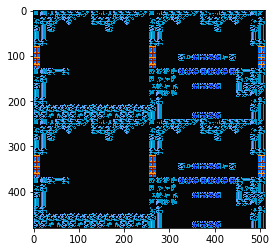

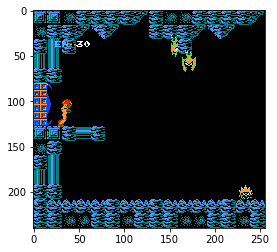

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.15050560236 0.976445436478 (22, 23) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 30
0 30 0 0 (0, 0)
Match1 0.145810887218 0.980856120586 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 30
0 30 0 30 (0, 0)
Match1 0.143711850047 0.98393535614 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 30 (0, 0)
Match1 0.142862141132 0.980650365353 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.143466070294 0.975502669811 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.14328314364 0.981718540192 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.144255980849 0.958746850491 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.141890272498 0.95182877779 (20, 23) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 

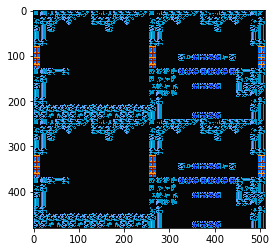

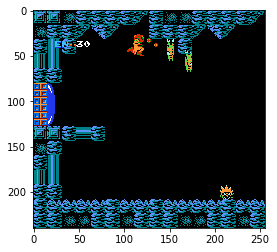

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.139065593481 0.97481918335 (22, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.133431136608 0.960417032242 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.134491533041 0.996722102165 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.13408434391 0.955877542496 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 30
0 30 0 0 (0, 0)
Match1 0.133510902524 0.969830930233 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 30 (0, 0)
Match1 0.132120236754 0.973095715046 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.133004009724 0.985979557037 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.132068186998 0.996426284313 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0

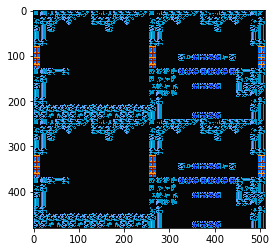

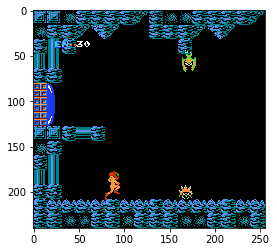

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.13348993659 0.977744042873 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.13325676322 0.968407034874 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.13515137136 0.982718169689 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.135222777724 0.982087492943 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.133818656206 0.967678844929 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.136437639594 0.972885549068 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.136097103357 0.979460656643 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.136750325561 0.958646178246 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2

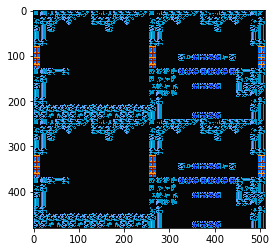

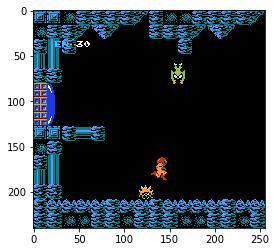

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.126072198153 0.974645972252 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.12778635323 0.951562941074 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.129839599133 0.99307847023 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 30
0 30 0 0 (0, 0)
Match1 0.130201607943 0.980819702148 (24, 22) (8, 8)
Sc1 Offset: 0 0 1072 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 30
0 30 0 30 (0, 0)
Match1 0.128405213356 0.947303771973 (23, 23) (9, 8)
Sc1 Offset: 1 0 1073 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 30 (0, 0)
Match1 0.123952940106 0.944145619869 (22, 23) (9, 8)
Sc1 Offset: 1 0 1074 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 30
0 30 0 0 (0, 0)
Match1 0.122693344951 0.946485877037 (23, 23) (10, 8)
Sc1 Offset: 2 0 1076 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 30 (0, 0)
Match1 0.122917346656 0.933464944363 (23, 22) (9, 8)
Sc1 Offset: 1 0 1077 0
NTS:
0 1 
2 3
M 1

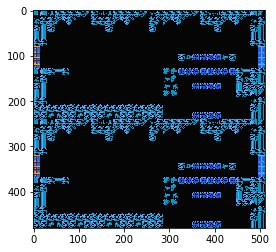

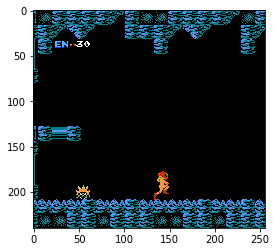

Sc2: 3 0
3 0 3 0 (0, 0)
Match1 0.144160583615 0.939547777176 (18, 24) (10, 8)
Sc1 Offset: 2 0 1101 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 0
3 0 3 0 (0, 0)
Match1 0.146941706538 0.931960046291 (20, 23) (9, 8)
Sc1 Offset: 1 0 1102 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 0
3 0 3 0 (0, 0)
Match1 0.148200005293 0.935544610023 (18, 24) (10, 8)
Sc1 Offset: 2 0 1104 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 4 0
4 0 3 0 (1, 0)
Match1 0.149024948478 0.942003071308 (17, 24) (9, 8)
Sc1 Offset: 1 0 1105 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 4 30
4 30 4 0 (0, 0)
Match1 0.144664958119 0.911451399326 (18, 24) (10, 8)
Sc1 Offset: 2 0 1107 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 4 0
4 0 4 30 (0, 0)
Match1 0.149351507425 0.949102520943 (17, 24) (9, 8)
Sc1 Offset: 1 0 1108 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 4 0
4 0 4 0 (0, 0)
Match1 0.150380030274 0.941201150417 (18, 24) (10, 8)
Sc1 Offset: 2 0 1110 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 4 0
4 0 4 0 (0, 0)
Match1 0.151383712888 0.935665249825 (17, 24) (9, 8)
Sc1 Offset: 1 0 1111 0
NTS:
0 1 
2 3
M 1 

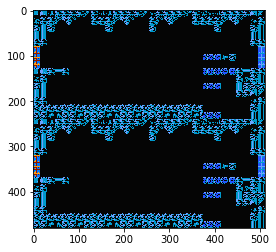

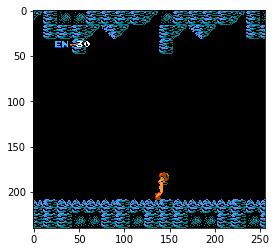

Sc2: 14 0
14 0 14 30 (0, 0)
Match1 0.162162318826 0.940549731255 (18, 24) (10, 8)
Sc1 Offset: 2 0 1191 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 14 0
14 0 14 0 (0, 0)
Match1 0.162317141891 0.956838607788 (17, 24) (9, 8)
Sc1 Offset: 1 0 1192 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 15 0
15 0 14 0 (1, 0)
Match1 0.160129353404 0.937295675278 (18, 24) (10, 8)
Sc1 Offset: 2 0 1194 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.161146849394 0.962714910507 (17, 24) (9, 8)
Sc1 Offset: 1 0 1195 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.160792291164 0.930434763432 (18, 24) (10, 8)
Sc1 Offset: 2 0 1197 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.162833049893 0.961745560169 (20, 23) (9, 8)
Sc1 Offset: 1 0 1198 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.160272181034 0.933156788349 (21, 23) (10, 8)
Sc1 Offset: 2 0 1200 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 16 0
16 0 15 0 (1, 0)
Match1 0.157193079591 0.947647571564 (20, 23) (9, 8)
Sc1 Offset: 1 0 120

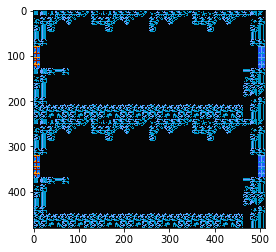

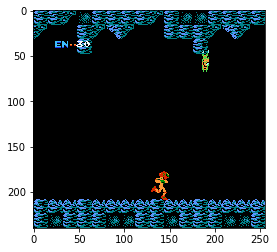

Sc2: 25 0
25 0 25 0 (0, 0)
Match1 0.148643761873 0.923923671246 (21, 23) (10, 8)
Sc1 Offset: 2 0 1281 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 26 0
26 0 25 0 (1, 0)
Match1 0.150944560766 0.935363352299 (20, 23) (9, 8)
Sc1 Offset: 1 0 1282 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 26 30
26 30 26 0 (0, 0)
Match1 0.153597638011 0.925708591938 (24, 22) (10, 8)
Sc1 Offset: 2 0 1284 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 26 0
26 0 26 30 (0, 0)
Match1 0.151440128684 0.953011035919 (20, 23) (9, 8)
Sc1 Offset: 1 0 1285 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.150221168995 0.910492062569 (21, 23) (10, 8)
Sc1 Offset: 2 0 1287 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 26 0
26 0 26 0 (0, 0)
Match1 0.148965761065 0.942678749561 (22, 23) (9, 8)
Sc1 Offset: 1 0 1288 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 27 0
27 0 26 0 (1, 0)
Match1 0.149365440011 0.910254120827 (21, 23) (10, 8)
Sc1 Offset: 2 0 1290 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 27 0
27 0 27 0 (0, 0)
Match1 0.148651584983 0.935947835445 (17, 24) (9, 8)
Sc1 Offset: 1 0 1

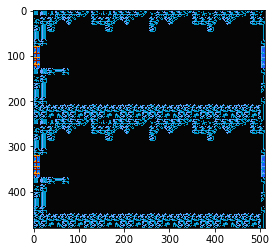

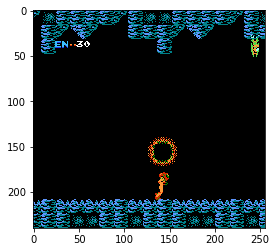

Sc2: 30 0
30 0 30 30 (0, 0)
Match1 0.161376178265 0.96684294939 (20, 23) (9, 8)
Sc1 Offset: 1 0 1320 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 30
31 30 30 0 (1, 0)
Match1 0.162894964218 0.958206653595 (20, 23) (9, 8)
Sc1 Offset: 1 0 1321 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 30 (0, 0)
Match1 0.159505784512 0.927938461304 (20, 23) (9, 8)
Sc1 Offset: 1 0 1322 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.168477803469 0.928251981735 (21, 23) (10, 8)
Sc1 Offset: 2 0 1324 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.169899463654 0.941913425922 (17, 24) (9, 8)
Sc1 Offset: 1 0 1325 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.165813267231 0.921026289463 (21, 23) (10, 8)
Sc1 Offset: 2 0 1327 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.167471885681 0.949783146381 (20, 23) (9, 8)
Sc1 Offset: 1 0 1328 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 30
0 30 31 0 (1, 0)
Match1 0.165742307901 0.987148702145 (19, 23) (8, 8)
Sc1 Offset: 0 0 132

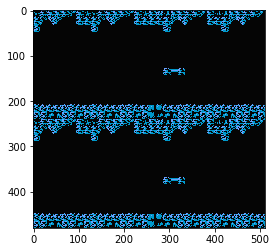

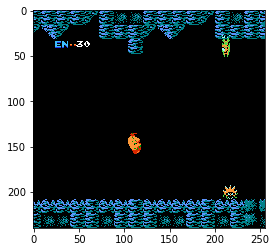

Sc2: 2 30
2 30 2 0 (0, 0)
Match1 0.149129807949 0.934946894646 (0, 24) (7, 8)
Sc1 Offset: -1 0 1350 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 2 0
2 0 2 30 (0, 0)
Match1 0.147239401937 0.968962490559 (0, 24) (8, 8)
Sc1 Offset: 0 0 1350 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 2 30
2 30 2 0 (0, 0)
Match1 0.148781225085 0.981191217899 (0, 24) (8, 8)
Sc1 Offset: 0 0 1350 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 2 0
2 0 2 30 (0, 0)
Match1 0.145667731762 0.947904825211 (0, 24) (8, 8)
Sc1 Offset: 0 0 1350 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 2 30
2 30 2 0 (0, 0)
Match1 0.14427408576 0.971850514412 (0, 24) (8, 8)
Sc1 Offset: 0 0 1350 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 2 0
2 0 2 30 (0, 0)
Match1 0.145561978221 0.962941110134 (0, 24) (8, 8)
Sc1 Offset: 0 0 1350 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 2 0
2 0 2 0 (0, 0)
Match1 0.146659210324 0.967538416386 (0, 24) (8, 8)
Sc1 Offset: 0 0 1350 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 2 0
2 0 2 0 (0, 0)
Match1 0.145899191499 0.979761302471 (0, 24) (8, 8)
Sc1 Offset: 0 0 1350 0
NTS:
3 2 
1 0
M 1 base 3

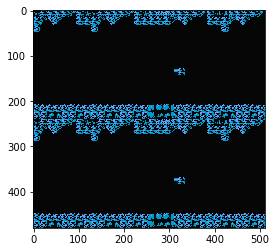

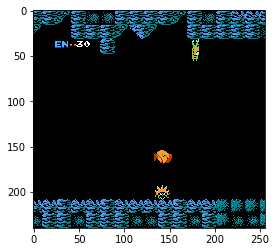

Sc2: 6 0
6 0 6 30 (0, 0)
Match1 0.153872460127 0.950270235538 (20, 23) (9, 8)
Sc1 Offset: 1 0 1383 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 6 30
6 30 6 0 (0, 0)
Match1 0.152887925506 0.916321396828 (20, 23) (9, 8)
Sc1 Offset: 1 0 1384 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 7 0
7 0 6 30 (1, 0)
Match1 0.148458614945 0.955476462841 (17, 24) (9, 8)
Sc1 Offset: 1 0 1385 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 7 0
7 0 7 0 (0, 0)
Match1 0.14702872932 0.929434120655 (17, 24) (9, 8)
Sc1 Offset: 1 0 1386 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 7 0
7 0 7 0 (0, 0)
Match1 0.14727447927 0.962730288506 (17, 24) (9, 8)
Sc1 Offset: 1 0 1387 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 7 0
7 0 7 0 (0, 0)
Match1 0.148542314768 0.910382866859 (17, 24) (9, 8)
Sc1 Offset: 1 0 1388 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 7 0
7 0 7 0 (0, 0)
Match1 0.146554782987 0.925113677979 (18, 24) (10, 8)
Sc1 Offset: 2 0 1390 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 7 0
7 0 7 0 (0, 0)
Match1 0.150148123503 0.908888339996 (20, 23) (9, 8)
Sc1 Offset: 1 0 1391 0
NTS:
3 2 
1 0
M 1 base

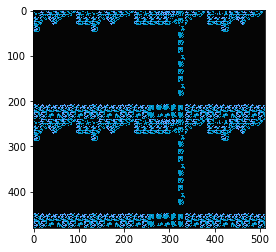

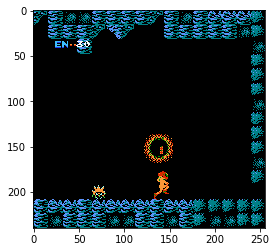

Sc2: 9 0
9 0 9 0 (0, 0)
Match1 0.152894958854 0.964779913425 (20, 23) (9, 8)
Sc1 Offset: 1 0 1408 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 10 0
10 0 9 0 (1, 0)
Match1 0.153459340334 0.904375493526 (21, 23) (10, 8)
Sc1 Offset: 2 0 1410 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 10 0
10 0 10 0 (0, 0)
Match1 0.163488909602 0.929993271828 (21, 23) (9, 8)
Sc1 Offset: 1 0 1411 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 10 0
10 0 10 0 (0, 0)
Match1 0.163703337312 0.933990597725 (21, 23) (10, 8)
Sc1 Offset: 2 0 1413 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 10 30
10 30 10 0 (0, 0)
Match1 0.160857796669 0.939238965511 (20, 23) (9, 8)
Sc1 Offset: 1 0 1414 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 10 0
10 0 10 30 (0, 0)
Match1 0.153653159738 0.920880198479 (2, 24) (10, 8)
Sc1 Offset: 2 0 1416 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 10 0 (1, 0)
Match1 0.161668688059 0.944113910198 (1, 24) (9, 8)
Sc1 Offset: 1 0 1417 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.166014760733 0.926896512508 (0, 19) (10, 8)
Sc1 Offset: 2 0 1419 0
N

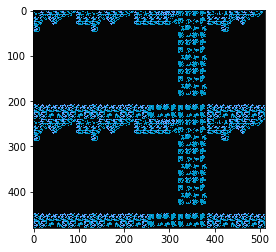

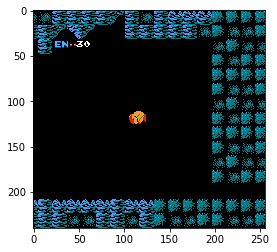

Sc2: 15 30
15 30 15 0 (0, 0)
Match1 0.121325023472 0.984099924564 (20, 18) (8, 8)
Sc1 Offset: 0 0 1451 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 30
15 30 15 30 (0, 0)
Match1 0.123004667461 0.987166166306 (20, 18) (8, 8)
Sc1 Offset: 0 0 1451 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 30
15 30 15 30 (0, 0)
Match1 0.1224097386 0.985337138176 (20, 18) (8, 8)
Sc1 Offset: 0 0 1451 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 30 (0, 0)
Match1 0.121198512614 0.98966729641 (20, 18) (8, 8)
Sc1 Offset: 0 0 1451 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.124330066144 0.961438953876 (19, 18) (7, 8)
Sc1 Offset: -1 0 1450 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.121055498719 0.97084414959 (19, 18) (7, 8)
Sc1 Offset: -1 0 1449 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.12326336652 0.962255775928 (19, 18) (7, 8)
Sc1 Offset: -1 0 1448 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.115924336016 0.951464474201 (18, 18) (6, 8)
Sc1 Offset: -2 0 

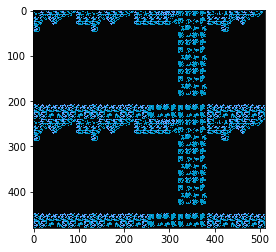

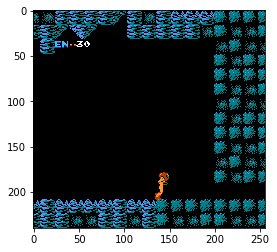

Sc2: 15 0
15 0 14 0 (1, 0)
Match1 0.120397113264 0.969117760658 (21, 18) (9, 8)
Sc1 Offset: 1 0 1449 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.120568066835 0.942841410637 (22, 18) (10, 8)
Sc1 Offset: 2 0 1451 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.119093373418 0.967033863068 (21, 18) (9, 8)
Sc1 Offset: 1 0 1452 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 30
15 30 15 0 (0, 0)
Match1 0.116386823356 0.943145871162 (19, 18) (10, 8)
Sc1 Offset: 2 0 1454 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 30 (0, 0)
Match1 0.115813270211 0.956759214401 (21, 18) (9, 8)
Sc1 Offset: 1 0 1455 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.11129271239 0.939881324768 (18, 16) (10, 8)
Sc1 Offset: 2 0 1457 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 0
16 0 15 0 (1, 0)
Match1 0.111165069044 0.966444849968 (21, 18) (9, 8)
Sc1 Offset: 1 0 1458 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 0
16 0 16 0 (0, 0)
Match1 0.1059596017 0.937061905861 (22, 18) (10, 8)
Sc1 Offset: 2 0 1460

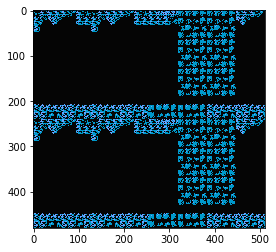

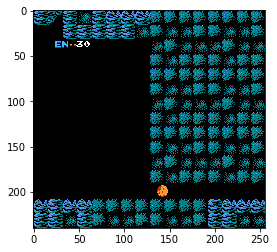

Sc2: 23 0
23 0 23 0 (0, 0)
Match1 0.0060504488647 0.979753613472 (17, 16) (9, 8)
Sc1 Offset: 1 0 1520 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 24 0
24 0 23 0 (1, 0)
Match1 0.00321581726894 0.963702917099 (18, 16) (10, 8)
Sc1 Offset: 2 0 1522 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 24 0
24 0 24 0 (0, 0)
Match1 0.00279610906728 0.978672683239 (17, 16) (9, 8)
Sc1 Offset: 1 0 1523 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 24 0
24 0 24 0 (0, 0)
Match1 -0.00238951481879 0.964435756207 (18, 16) (10, 8)
Sc1 Offset: 2 0 1525 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 24 0
24 0 24 0 (0, 0)
Match1 -0.00397890107706 0.97940993309 (17, 16) (9, 8)
Sc1 Offset: 1 0 1526 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 24 0
24 0 24 0 (0, 0)
Match1 -0.00805537030101 0.96497708559 (18, 16) (10, 8)
Sc1 Offset: 2 0 1528 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 25 0
25 0 24 0 (1, 0)
Match1 -0.00907660648227 0.979317069054 (17, 16) (9, 8)
Sc1 Offset: 1 0 1529 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 25 0
25 0 25 0 (0, 0)
Match1 -0.0123987374827 0.965333521366 (18, 16) (10, 8)
Sc1

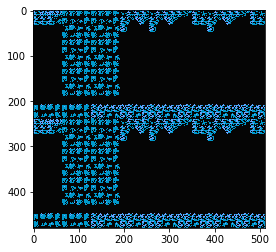

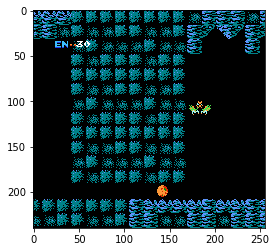

Sc2: 2 0
2 0 2 0 (0, 0)
Match1 -0.00672837113962 0.95732319355 (17, 16) (9, 8)
Sc1 Offset: 1 0 1607 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 2 0
2 0 2 0 (0, 0)
Match1 -0.00426404643804 0.959026515484 (1, 0) (10, 8)
Sc1 Offset: 2 0 1609 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 0
3 0 2 0 (1, 0)
Match1 -0.00570807885379 0.965320527554 (18, 16) (9, 8)
Sc1 Offset: 1 0 1610 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 0
3 0 3 0 (0, 0)
Match1 -0.00516379298642 0.95837020874 (1, 0) (10, 8)
Sc1 Offset: 2 0 1612 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 0
3 0 3 0 (0, 0)
Match1 -0.00635858485475 0.957319676876 (17, 16) (9, 8)
Sc1 Offset: 1 0 1613 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 0
3 0 3 0 (0, 0)
Match1 -0.00581675861031 0.95269292593 (18, 16) (10, 8)
Sc1 Offset: 2 0 1615 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 30
3 30 3 0 (0, 0)
Match1 -0.00702344859019 0.960660517216 (17, 16) (9, 8)
Sc1 Offset: 1 0 1616 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 4 0
4 0 3 30 (1, 0)
Match1 -0.00371066015214 0.959574282169 (1, 0) (10, 8)
Sc1 Offset: 2 0 1618 0
NTS

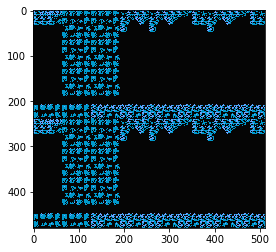

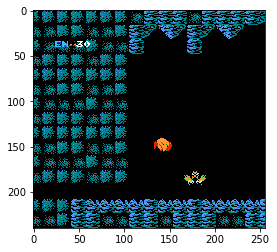

Sc2: 10 0
10 0 10 0 (0, 0)
Match1 0.0649433657527 0.958824038506 (0, 0) (9, 8)
Sc1 Offset: 1 0 1671 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 10 0
10 0 10 0 (0, 0)
Match1 0.0703738927841 0.975066542625 (0, 0) (9, 8)
Sc1 Offset: 1 0 1672 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 11 30
11 30 10 0 (1, 0)
Match1 0.0654218047857 0.950549185276 (0, 0) (9, 8)
Sc1 Offset: 1 0 1673 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 11 0
11 0 11 30 (0, 0)
Match1 0.0692109167576 0.979498744011 (0, 0) (9, 8)
Sc1 Offset: 1 0 1674 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.0671366304159 0.949452280998 (0, 0) (9, 8)
Sc1 Offset: 1 0 1675 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.0707507655025 0.96573227644 (0, 0) (9, 8)
Sc1 Offset: 1 0 1676 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.071435585618 0.936603784561 (1, 0) (10, 8)
Sc1 Offset: 2 0 1678 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 11 0
11 0 11 0 (0, 0)
Match1 0.0747358873487 0.959390103817 (0, 0) (9, 8)
Sc1 Offset: 1 0 1679 0
NTS:
0 

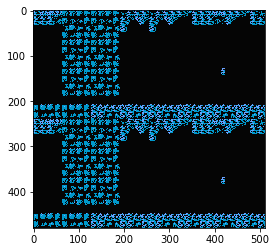

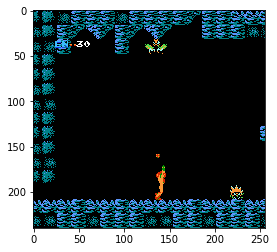

Sc2: 20 0
20 0 20 0 (0, 0)
Match1 0.150544300675 0.931266546249 (20, 23) (9, 8)
Sc1 Offset: 1 0 1751 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 20 0
20 0 20 0 (0, 0)
Match1 0.149779260159 0.909913599491 (21, 23) (10, 8)
Sc1 Offset: 2 0 1753 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 20 0 (1, 0)
Match1 0.148550525308 0.933792114258 (20, 23) (9, 8)
Sc1 Offset: 1 0 1754 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.14824795723 0.924803733826 (21, 23) (10, 8)
Sc1 Offset: 2 0 1756 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.152512684464 0.910104095936 (20, 23) (9, 8)
Sc1 Offset: 1 0 1757 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 30
21 30 21 0 (0, 0)
Match1 0.153236582875 0.918324053288 (21, 23) (10, 8)
Sc1 Offset: 2 0 1759 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 30 (0, 0)
Match1 0.154317066073 0.921123802662 (20, 23) (9, 8)
Sc1 Offset: 1 0 1760 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 30
22 30 21 0 (1, 0)
Match1 0.156500473619 0.904627203941 (21, 23) (10, 8)
Sc1 Offset: 2 0 

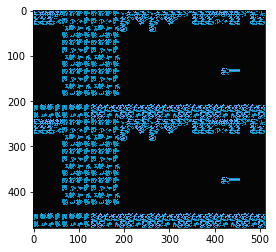

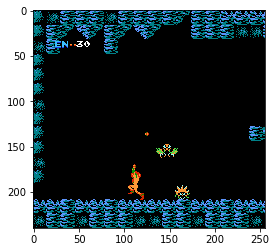

Sc2: 22 30
22 30 22 0 (0, 0)
Match1 0.15082757175 0.928851366043 (15, 24) (7, 8)
Sc1 Offset: -1 0 1761 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 0
22 0 22 30 (0, 0)
Match1 0.14761736989 0.895190954208 (17, 23) (6, 8)
Sc1 Offset: -2 0 1759 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 22 0 (-1, 0)
Match1 0.142154246569 0.93100631237 (18, 23) (7, 8)
Sc1 Offset: -1 0 1758 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.140760973096 0.896391451359 (17, 23) (6, 8)
Sc1 Offset: -2 0 1756 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.141184493899 0.925972700119 (18, 23) (7, 8)
Sc1 Offset: -1 0 1755 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.145032122731 0.911952316761 (17, 23) (6, 8)
Sc1 Offset: -2 0 1753 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 30
21 30 21 0 (0, 0)
Match1 0.144675284624 0.921879768372 (18, 23) (7, 8)
Sc1 Offset: -1 0 1752 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 30 (0, 0)
Match1 0.146758377552 0.904527366161 (18, 23) (6, 8)
Sc1 Offset: -

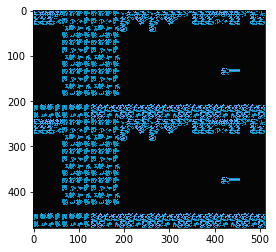

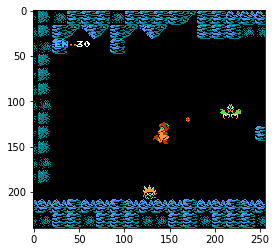

Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.145098507404 0.912944614887 (20, 23) (9, 8)
Sc1 Offset: 1 0 1756 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.138679847121 0.953031361103 (17, 24) (9, 8)
Sc1 Offset: 1 0 1757 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.142912089825 0.890967488289 (18, 24) (10, 8)
Sc1 Offset: 2 0 1759 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 21 0
21 0 21 0 (0, 0)
Match1 0.143192693591 0.909872353077 (20, 23) (9, 8)
Sc1 Offset: 1 0 1760 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 0
22 0 21 0 (1, 0)
Match1 0.147114098072 0.902282714844 (20, 23) (9, 8)
Sc1 Offset: 1 0 1761 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 0
22 0 22 0 (0, 0)
Match1 0.145491451025 0.938989460468 (17, 24) (9, 8)
Sc1 Offset: 1 0 1762 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 0
22 0 22 0 (0, 0)
Match1 0.153603777289 0.902638375759 (22, 23) (9, 8)
Sc1 Offset: 1 0 1763 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 22 0
22 0 22 0 (0, 0)
Match1 0.145870983601 0.947040736675 (17, 24) (9, 8)
Sc1 Offset: 1 0 1764 0


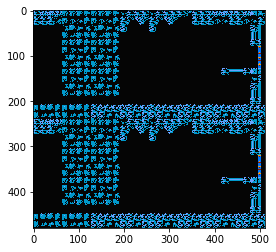

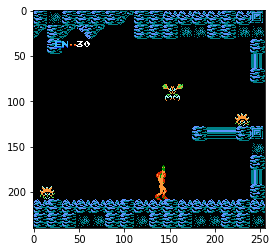

Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.111417606473 0.971876680851 (19, 23) (8, 8)
Sc1 Offset: 0 0 1824 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.111577808857 0.951017439365 (19, 23) (8, 8)
Sc1 Offset: 0 0 1824 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.112097136676 0.97504222393 (19, 23) (8, 8)
Sc1 Offset: 0 0 1824 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.112240850925 0.943695962429 (19, 23) (8, 8)
Sc1 Offset: 0 0 1824 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.113219864666 0.972987532616 (19, 23) (8, 8)
Sc1 Offset: 0 0 1824 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.111871033907 0.943735599518 (19, 23) (8, 8)
Sc1 Offset: 0 0 1824 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.111558146775 0.97139698267 (19, 23) (8, 8)
Sc1 Offset: 0 0 1824 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.110946834087 0.948953151703 (19, 23) (8, 8)
Sc1 Offset: 0 0 1824 0
NTS

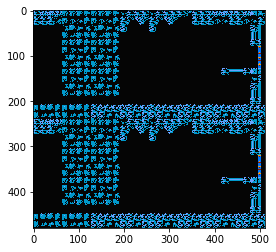

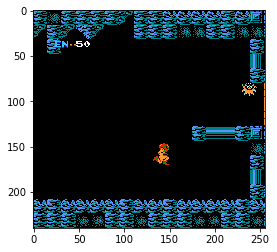

Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.105764165521 0.948530554771 (22, 23) (9, 8)
Sc1 Offset: 1 0 1826 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.104538239539 0.952646255493 (22, 23) (9, 8)
Sc1 Offset: 1 0 1827 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.107205852866 0.946396529675 (22, 23) (9, 8)
Sc1 Offset: 1 0 1828 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 30
30 30 30 0 (0, 0)
Match1 0.110297888517 0.946269869804 (20, 23) (9, 8)
Sc1 Offset: 1 0 1829 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 30 (0, 0)
Match1 0.110918343067 0.956383764744 (20, 23) (9, 8)
Sc1 Offset: 1 0 1830 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.116609796882 0.962839305401 (20, 23) (9, 8)
Sc1 Offset: 1 0 1831 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.116269461811 0.94849640131 (17, 24) (9, 8)
Sc1 Offset: 1 0 1832 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 0
31 0 30 0 (1, 0)
Match1 0.116781584918 0.955519378185 (17, 24) (9, 8)
Sc1 Offset: 1 0 1833 0

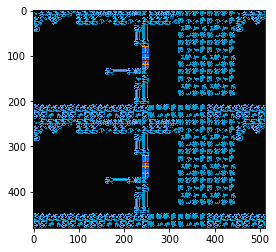

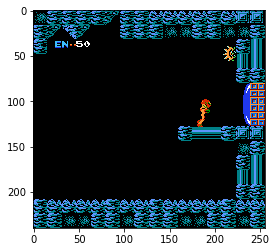

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.144454792142 0.983773052692 (0, 24) (8, 8)
Sc1 Offset: 0 0 1840 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.14210550487 0.982062041759 (0, 24) (8, 8)
Sc1 Offset: 0 0 1840 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 30
0 30 0 0 (0, 0)
Match1 0.142142519355 0.973500788212 (0, 24) (8, 8)
Sc1 Offset: 0 0 1840 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 30 (0, 0)
Match1 0.142349436879 0.964129209518 (0, 24) (8, 8)
Sc1 Offset: 0 0 1840 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.141534298658 0.974348306656 (0, 24) (8, 8)
Sc1 Offset: 0 0 1840 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.142717644572 0.97068798542 (0, 24) (8, 8)
Sc1 Offset: 0 0 1840 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.138403147459 0.963216245174 (0, 24) (8, 8)
Sc1 Offset: 0 0 1840 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.143005415797 0.970913112164 (0, 24) (8, 8)
Sc1 Offset: 0 0 1840 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 

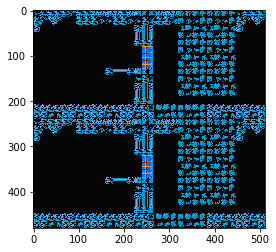

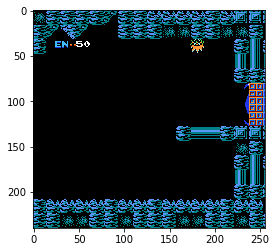

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.146502092481 0.954482495785 (2, 24) (10, 8)
Sc1 Offset: 2 0 1844 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.151881933212 0.956857442856 (2, 24) (10, 8)
Sc1 Offset: 2 0 1846 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.152100637555 0.956482589245 (2, 24) (10, 8)
Sc1 Offset: 2 0 1848 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 1 0
1 0 0 0 (1, 0)
Match1 0.163836658001 0.958992958069 (1, 22) (10, 8)
Sc1 Offset: 2 0 1850 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 1 0
1 0 1 0 (0, 0)
Match1 0.165950626135 0.959593594074 (1, 22) (10, 8)
Sc1 Offset: 2 0 1852 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 1 0
1 0 1 0 (0, 0)
Match1 0.171478509903 0.96564912796 (1, 22) (10, 8)
Sc1 Offset: 2 0 1854 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 1 30
1 30 1 0 (0, 0)
Match1 0.166294872761 0.972654283047 (1, 22) (10, 8)
Sc1 Offset: 2 0 1856 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 2 0
2 0 1 30 (1, 0)
Match1 0.16787828505 0.973314762115 (1, 22) (10, 8)
Sc1 Offset: 2 0 1858 0
NTS:
3 2 
1 0
M 1 base 3

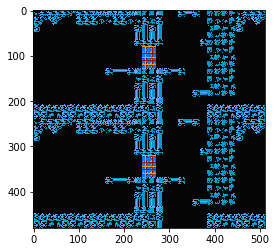

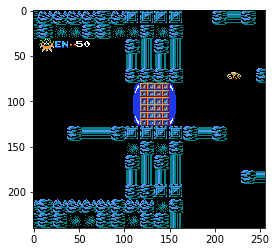

Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.160053610802 0.965409219265 (22, 23) (10, 8)
Sc1 Offset: 2 0 1964 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.159647166729 0.972246170044 (22, 23) (10, 8)
Sc1 Offset: 2 0 1966 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 15 0
15 0 15 0 (0, 0)
Match1 0.161958247423 0.968219101429 (22, 23) (10, 8)
Sc1 Offset: 2 0 1968 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 0
16 0 15 0 (1, 0)
Match1 0.161587208509 0.97782844305 (22, 23) (10, 8)
Sc1 Offset: 2 0 1970 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 30
16 30 16 0 (0, 0)
Match1 0.162239521742 0.972673475742 (22, 23) (10, 8)
Sc1 Offset: 2 0 1972 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 0
16 0 16 30 (0, 0)
Match1 0.160387933254 0.977898955345 (22, 23) (10, 8)
Sc1 Offset: 2 0 1974 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 16 0
16 0 16 0 (0, 0)
Match1 0.158116698265 0.972739756107 (22, 23) (10, 8)
Sc1 Offset: 2 0 1976 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 17 0
17 0 16 0 (1, 0)
Match1 0.156865373254 0.977906227112 (22, 23) (10, 8)
Sc1 Offset: 2 

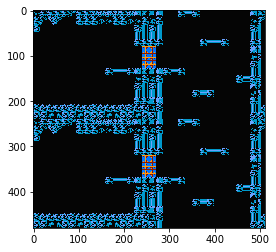

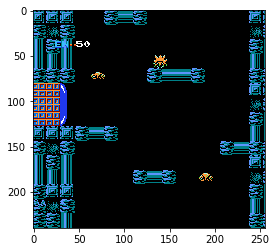

Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.120378367603 0.96584045887 (22, 23) (10, 8)
Sc1 Offset: 2 0 2084 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.126520752907 0.959580361843 (22, 23) (10, 8)
Sc1 Offset: 2 0 2086 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 30 0
30 0 30 0 (0, 0)
Match1 0.142259553075 0.952914357185 (22, 23) (10, 8)
Sc1 Offset: 2 0 2088 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 31 0
31 0 30 0 (1, 0)
Match1 0.145373150706 0.95137989521 (22, 23) (10, 8)
Sc1 Offset: 2 0 2090 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 31 0
31 0 31 0 (0, 0)
Match1 0.152676656842 0.956923425198 (22, 23) (10, 8)
Sc1 Offset: 2 0 2092 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 31 30
31 30 31 0 (0, 0)
Match1 0.134471267462 0.948761701584 (24, 24) (10, 8)
Sc1 Offset: 2 0 2094 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 31 0
31 0 31 30 (0, 0)
Match1 0.118994414806 0.946105182171 (24, 24) (10, 8)
Sc1 Offset: 2 0 2096 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 31 0 (1, 0)
Match1 0.114963069558 0.975645184517 (24, 24) (8, 8)
Sc1 Offset: 0 0 20

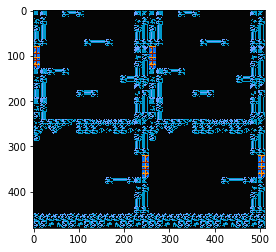

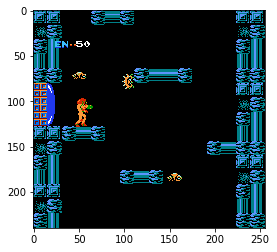

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.102466583252 0.978404521942 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.102199666202 0.978404581547 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.102199688554 0.977121889591 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.102121062577 0.978404521942 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.10212110728 0.992462337017 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.102121062577 0.985326826572 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.102121062577 0.978404521942 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.102121084929 0.978404521942 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 0
NTS:
0 1 
2 3
M 0 base 0
S

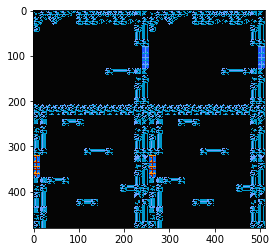

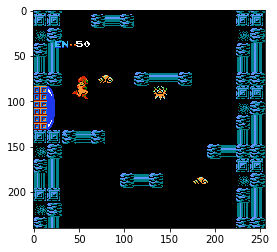

Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.100341394544 0.974155724049 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -4
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.10028796643 0.96804702282 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -4
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.100501678884 0.98191177845 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -4
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.100516542792 0.974169254303 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -4
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.100688919425 0.96804690361 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -4
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.100276678801 0.96804702282 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -4
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.100177787244 0.974155843258 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -4
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.100177042186 0.963240981102 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -

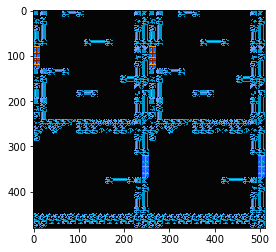

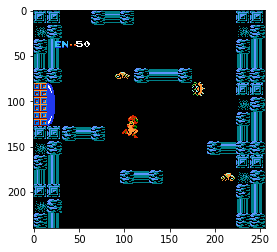

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.111290261149 0.983147263527 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.110396236181 1.0 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.110396236181 1.0 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.113394208252 0.931432306767 (24, 24) (8, 9)
Sc1 Offset: 0 1 2096 1
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.11443991214 0.938920199871 (22, 24) (8, 10)
Sc1 Offset: 0 2 2096 3
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.108361676335 0.933887004852 (22, 24) (8, 10)
Sc1 Offset: 0 2 2096 5
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.106785029173 0.940143883228 (22, 24) (8, 10)
Sc1 Offset: 0 2 2096 7
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.101759977639 0.92746680975 (22, 24) (8, 10)
Sc1 Offset: 0 2 2096 9
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 1
0 1 0 0 (0,

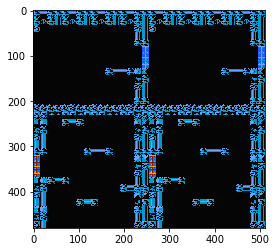

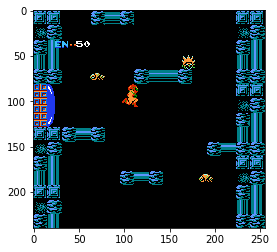

Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0956791862845 0.973656594753 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -1
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0956791862845 0.978276252747 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -1
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0956791639328 0.978276252747 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -1
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0956791639328 0.976547062397 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -1
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0956791415811 0.978276252747 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -1
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0959801375866 0.978276252747 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -1
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.096091195941 0.984506309032 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -1
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.096091195941 0.98155272007 (24, 24) (8, 8)
Sc1 Offset: 

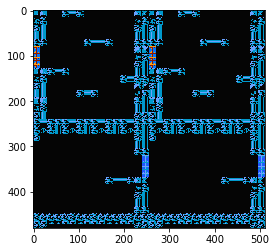

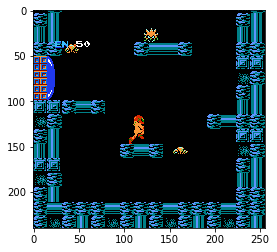

Sc2: 0 3
0 3 0 3 (0, 0)
Match1 0.11882071197 0.983695566654 (20, 23) (8, 8)
Sc1 Offset: 0 0 2096 29
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 3
0 3 0 3 (0, 0)
Match1 0.120777852833 0.961143136024 (20, 23) (8, 8)
Sc1 Offset: 0 0 2096 29
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 3
0 3 0 3 (0, 0)
Match1 0.121044978499 0.971298158169 (20, 23) (8, 8)
Sc1 Offset: 0 0 2096 29
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 3
0 3 0 3 (0, 0)
Match1 0.120306178927 0.964060306549 (20, 23) (8, 8)
Sc1 Offset: 0 0 2096 29
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 3
0 3 0 3 (0, 0)
Match1 0.120819054544 0.96691930294 (20, 23) (8, 8)
Sc1 Offset: 0 0 2096 29
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 3
0 3 0 3 (0, 0)
Match1 0.121336705983 0.968389332294 (20, 23) (8, 8)
Sc1 Offset: 0 0 2096 29
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 3
0 3 0 3 (0, 0)
Match1 0.121821507812 0.973203659058 (20, 23) (8, 8)
Sc1 Offset: 0 0 2096 29
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 3
0 3 0 3 (0, 0)
Match1 0.119913600385 0.977392673492 (20, 23) (8, 8)
Sc1 Offset: 0 0 2096 29
NTS:
0 1 
2 3
M 0 b

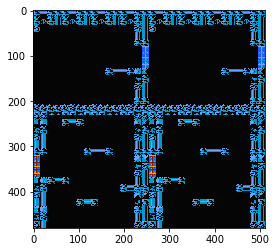

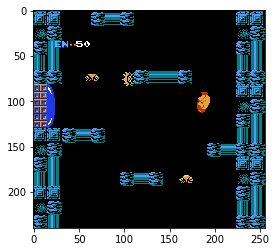

Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0954948738217 0.968555986881 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -2
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0952004939318 0.9671677351 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -2
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0944724604487 0.964790284634 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -2
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0939581990242 0.967617809772 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -2
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0941790938377 0.963379085064 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -2
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0947243869305 0.980511724949 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -2
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0941745787859 0.969016551971 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -2
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0935840979218 0.965593159199 (24, 24) (8, 8)
Sc1 Offset:

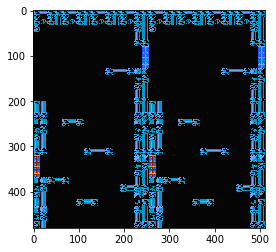

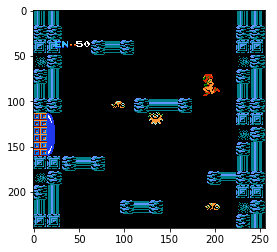

Sc2: 0 25
0 25 0 26 (0, -1)
Match1 0.0902035981417 0.948869168758 (24, 23) (8, 7)
Sc1 Offset: 0 -1 2096 -34
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 25
0 25 0 25 (0, 0)
Match1 0.0925729572773 0.955050289631 (24, 24) (8, 7)
Sc1 Offset: 0 -1 2096 -35
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 25
0 25 0 25 (0, 0)
Match1 0.0945678800344 0.948324918747 (24, 24) (8, 7)
Sc1 Offset: 0 -1 2096 -36
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 25
0 25 0 25 (0, 0)
Match1 0.0955592542887 0.96246701479 (24, 24) (8, 7)
Sc1 Offset: 0 -1 2096 -37
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 25
0 25 0 25 (0, 0)
Match1 0.0966222733259 0.959401547909 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -37
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 25
0 25 0 25 (0, 0)
Match1 0.096907787025 0.939892709255 (24, 24) (8, 7)
Sc1 Offset: 0 -1 2096 -38
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 25
0 25 0 25 (0, 0)
Match1 0.0990053936839 0.949736893177 (24, 24) (8, 7)
Sc1 Offset: 0 -1 2096 -39
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 25
0 25 0 25 (0, 0)
Match1 0.10171957314 0.963782250881 (24, 24) (8, 8)

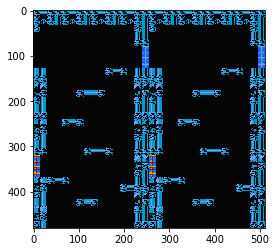

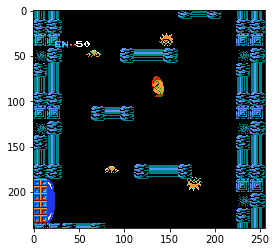

Sc2: 0 16
0 16 0 17 (0, -1)
Match1 0.087486974895 0.929591953754 (24, 23) (8, 7)
Sc1 Offset: 0 -1 2096 -107
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 16
0 16 0 16 (0, 0)
Match1 0.0894782841206 0.906381189823 (24, 22) (8, 6)
Sc1 Offset: 0 -2 2096 -109
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 16
0 16 0 16 (0, 0)
Match1 0.0897089093924 0.928315758705 (24, 24) (8, 7)
Sc1 Offset: 0 -1 2096 -110
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 16
0 16 0 16 (0, 0)
Match1 0.0888232439756 0.949797570705 (24, 23) (8, 7)
Sc1 Offset: 0 -1 2096 -111
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 16
0 16 0 16 (0, 0)
Match1 0.0850202590227 0.917397797108 (24, 21) (8, 6)
Sc1 Offset: 0 -2 2096 -113
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 15
0 15 0 16 (0, -1)
Match1 0.085987046361 0.922082066536 (24, 23) (8, 7)
Sc1 Offset: 0 -1 2096 -114
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 15
0 15 0 15 (0, 0)
Match1 0.0823312476277 0.935497283936 (24, 22) (8, 7)
Sc1 Offset: 0 -1 2096 -115
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 15
0 15 0 15 (0, 0)
Match1 0.0796503424644 0.935709357262 (24,

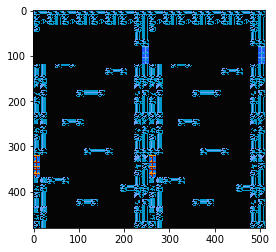

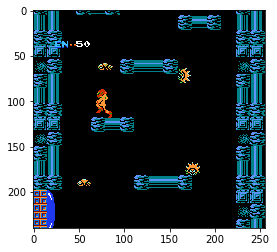

Sc2: 0 15
0 15 0 15 (0, 0)
Match1 0.0790596306324 0.948007047176 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -118
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 15
0 15 0 15 (0, 0)
Match1 0.0797536820173 0.974528670311 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -118
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 15
0 15 0 15 (0, 0)
Match1 0.0805730223656 0.94243735075 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -118
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 15
0 15 0 15 (0, 0)
Match1 0.0788848176599 0.956076443195 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -118
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 15
0 15 0 15 (0, 0)
Match1 0.0813136696815 0.943577170372 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -118
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 15
0 15 0 15 (0, 0)
Match1 0.0796347334981 0.971347868443 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -118
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 15
0 15 0 15 (0, 0)
Match1 0.0800406560302 0.963952839375 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -118
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 15
0 15 0 15 (0, 0)
Match1 0.0797551050782 0.986924111843 (24, 24) (8,

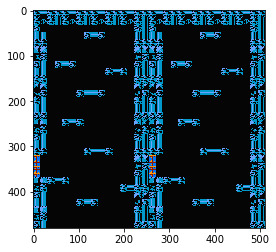

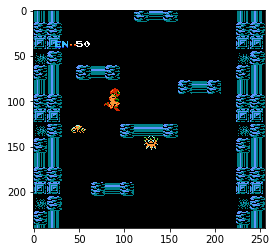

Sc2: 0 6
0 6 0 6 (0, 0)
Match1 0.0832217186689 0.94364798069 (24, 24) (8, 7)
Sc1 Offset: 0 -1 2096 -190
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 6
0 6 0 6 (0, 0)
Match1 0.0811619237065 0.945533692837 (24, 23) (8, 7)
Sc1 Offset: 0 -1 2096 -191
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 6
0 6 0 6 (0, 0)
Match1 0.079936273396 0.930524110794 (24, 22) (8, 6)
Sc1 Offset: 0 -2 2096 -193
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 5
0 5 0 6 (0, -1)
Match1 0.0794395655394 0.941552698612 (24, 23) (8, 7)
Sc1 Offset: 0 -1 2096 -194
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 5
0 5 0 5 (0, 0)
Match1 0.0802324339747 0.954977989197 (24, 23) (8, 7)
Sc1 Offset: 0 -1 2096 -195
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 5
0 5 0 5 (0, 0)
Match1 0.0795537754893 0.953337490559 (24, 23) (8, 7)
Sc1 Offset: 0 -1 2096 -196
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 5
0 5 0 5 (0, 0)
Match1 0.0821850001812 0.960033714771 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -196
NTS:
3 2 
1 0
M 0 base 3
Sc2: 0 5
0 5 0 5 (0, 0)
Match1 0.0813109502196 0.937220394611 (24, 23) (8, 7)
Sc1 Offset: 0 

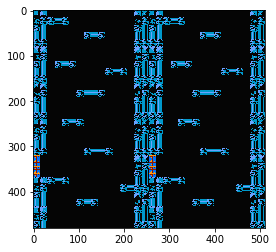

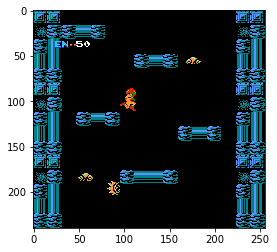

Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0650110840797 0.917917609215 (24, 22) (8, 6)
Sc1 Offset: 0 -2 2096 -242
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 29
0 29 0 0 (0, -1)
Match1 0.068600282073 0.949385523796 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -242
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0686003044248 0.962813675404 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -242
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0686003044248 0.969721496105 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -242
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.068600282073 0.976929843426 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -242
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0689764544368 0.963278770447 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -242
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0689417123795 0.971430718899 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -242
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 29
0 29 0 29 (0, 0)
Match1 0.0689764097333 0.963278770447 (24, 24) (8, 8)

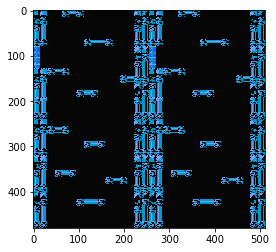

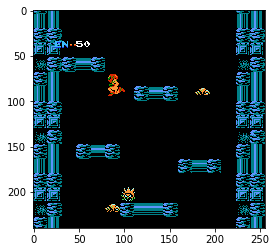

Sc2: 0 25
0 25 0 25 (0, 0)
Match1 0.0886598974466 0.916357278824 (24, 20) (8, 5)
Sc1 Offset: 0 -3 2096 -279
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 25
0 25 0 25 (0, 0)
Match1 0.0907241404057 0.927945613861 (24, 22) (8, 6)
Sc1 Offset: 0 -2 2096 -281
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 24
0 24 0 25 (0, -1)
Match1 0.0887708961964 0.921125650406 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 -284
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 24
0 24 0 24 (0, 0)
Match1 0.0997973382473 0.929935276508 (24, 24) (8, 6)
Sc1 Offset: 0 -2 2096 -286
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 24
0 24 0 24 (0, 0)
Match1 0.103186629713 0.930538594723 (24, 24) (8, 6)
Sc1 Offset: 0 -2 2096 -288
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 24
0 24 0 24 (0, 0)
Match1 0.1037896052 0.938695788383 (24, 24) (8, 6)
Sc1 Offset: 0 -2 2096 -290
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 23
0 23 0 24 (0, -1)
Match1 0.105806410313 0.934474110603 (24, 24) (8, 6)
Sc1 Offset: 0 -2 2096 -292
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 23
0 23 0 23 (0, 0)
Match1 0.106784567237 0.955268800259 (24, 24)

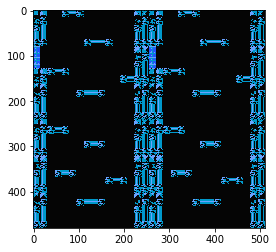

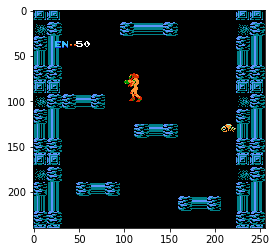

Sc2: 0 20
0 20 0 20 (0, 0)
Match1 0.0806102454662 0.934390902519 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 -320
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 20
0 20 0 20 (0, 0)
Match1 0.0796560496092 0.94539898634 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 -323
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 19
0 19 0 20 (0, -1)
Match1 0.0750529393554 0.931917667389 (24, 23) (8, 4)
Sc1 Offset: 0 -4 2096 -327
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 19
0 19 0 19 (0, 0)
Match1 0.0805081352592 0.944403707981 (24, 22) (8, 6)
Sc1 Offset: 0 -2 2096 -329
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 18
0 18 0 19 (0, -1)
Match1 0.0797596722841 0.934661746025 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 -332
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 18
0 18 0 18 (0, 0)
Match1 0.0831718593836 0.943314611912 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 -335
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 18
0 18 0 18 (0, 0)
Match1 0.0857860147953 0.936106860638 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 -338
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 17
0 17 0 18 (0, -1)
Match1 0.0947051346302 0.942765176296 (2

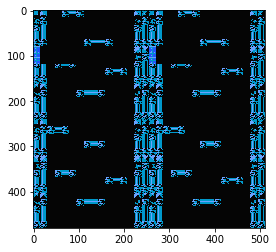

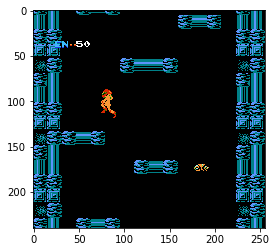

Sc2: 0 15
0 15 0 15 (0, 0)
Match1 0.101976044476 0.939764678478 (24, 24) (8, 6)
Sc1 Offset: 0 -2 2096 -359
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 15
0 15 0 15 (0, 0)
Match1 0.0941812768579 0.933993756771 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 -362
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 14
0 14 0 15 (0, -1)
Match1 0.0955022200942 0.932242512703 (24, 23) (8, 4)
Sc1 Offset: 0 -4 2096 -366
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 14
0 14 0 14 (0, 0)
Match1 0.098005592823 0.936329245567 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 -369
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 13
0 13 0 14 (0, -1)
Match1 0.0972172692418 0.93086707592 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 -372
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 13
0 13 0 13 (0, 0)
Match1 0.0910984277725 0.936526179314 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 -375
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 13
0 13 0 13 (0, 0)
Match1 0.0862339064479 0.926967024803 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 -378
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 12
0 12 0 13 (0, -1)
Match1 0.0835439413786 0.933741271496 (24,

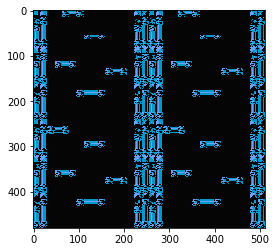

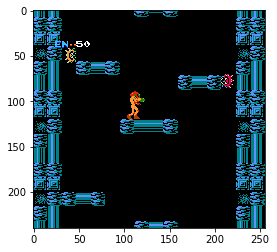

Sc2: 0 7
0 7 0 7 (0, 0)
Match1 0.110880598426 0.971061110497 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -424
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 7
0 7 0 7 (0, 0)
Match1 0.109504185617 0.977915525436 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -424
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 7
0 7 0 7 (0, 0)
Match1 0.10834479332 0.963271975517 (24, 24) (8, 8)
Sc1 Offset: 0 0 2096 -424
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 7
0 7 0 7 (0, 0)
Match1 0.102122813463 0.907925844193 (24, 23) (8, 4)
Sc1 Offset: 0 -4 2096 -428
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 6
0 6 0 7 (0, -1)
Match1 0.101868994534 0.912178039551 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 -431
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 6
0 6 0 6 (0, 0)
Match1 0.100315585732 0.926556587219 (24, 23) (8, 4)
Sc1 Offset: 0 -4 2096 -435
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 5
0 5 0 6 (0, -1)
Match1 0.100198321044 0.929483473301 (24, 23) (8, 4)
Sc1 Offset: 0 -4 2096 -439
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 5
0 5 0 5 (0, 0)
Match1 0.100289873779 0.912890791893 (24, 24) (8, 5)
Sc1 Offset: 0 -3 2096 

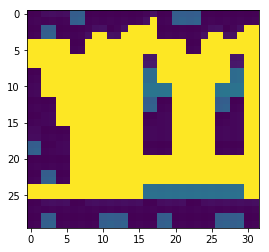

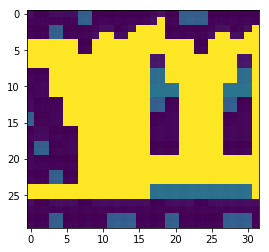

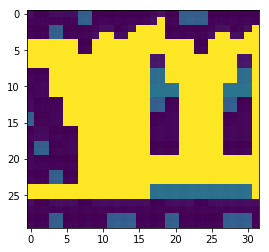

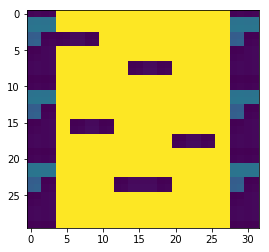

In [3]:
reload(ppu_dump)



ep_data = ppu_dump.ppu_output(emu,
                              inputs[start_t:-1],
                              bg_data=True,
                              scrolling=True,
                              sprite_data=False,
                              colorized_tiles=False,
                              display=False,
                              test_control=True)
nt = ep_data["nametables"][0]
plt.imshow(nt)
plt.show()
nt = ep_data["nametables"][1]
plt.imshow(nt)
plt.show()
nt = ep_data["nametables"][2]
plt.imshow(nt)
plt.show()

nt = ep_data["nametables"][-1]
plt.imshow(nt)
plt.show()

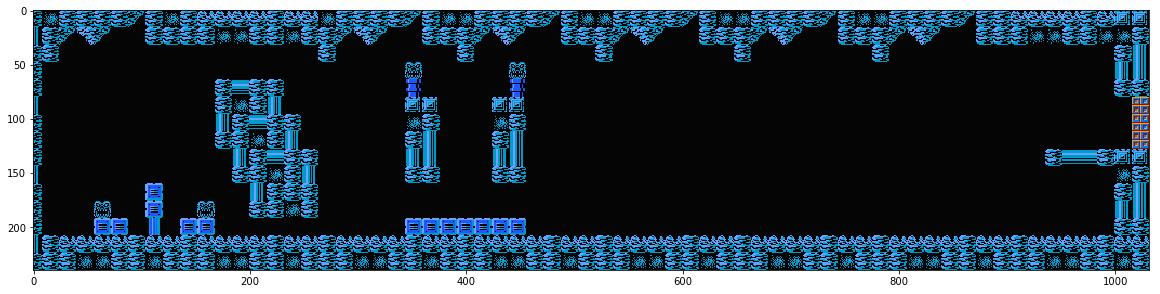

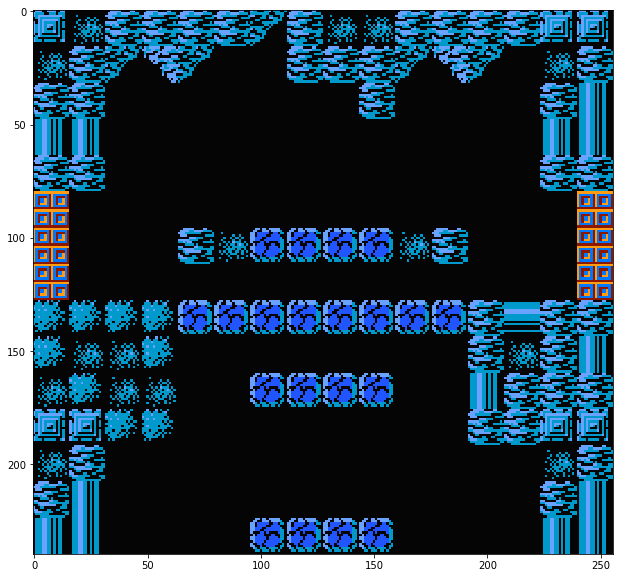

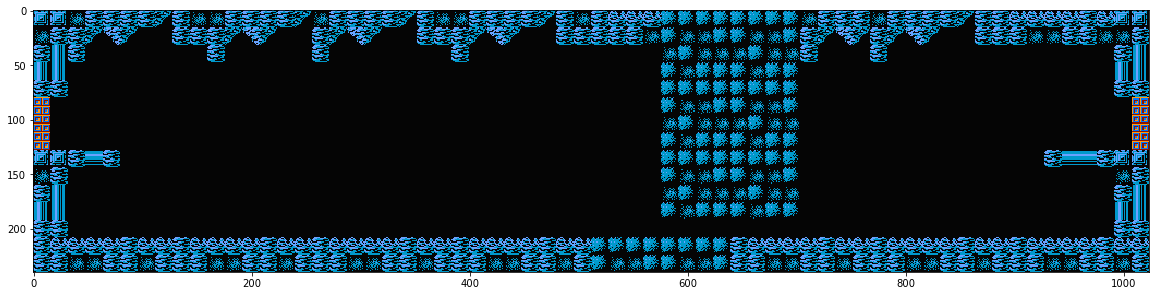

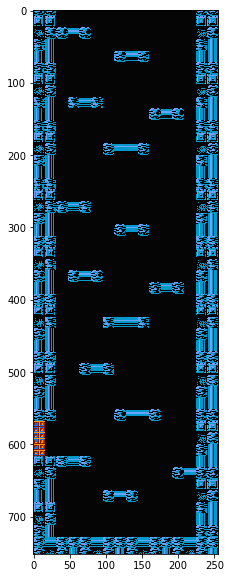

In [12]:
posx, posy = 0, 0
nt_total = {}
nt_totals = [nt_total]
tilex = 0
tiley = 0
interstitial = False
for t, (sx, sy) in sorted(ep_data["tilemap_motion"].items()):
    nt = ep_data["nametables"][t]
    attr = ep_data["attr"][t]
    if sx >= 16:
        sx -= 32
    if sx <= -16:
        sx += 32
    if sy >= 15:
        sy -= 30
    if sy <= -15:
        sy += 30
    
    tilex += sx
    tiley += sy
    if not ep_data['has_controls'][t] and (sx != 0 or sy != 0):
        interstitial = True
    if ep_data['has_controls'][t] and interstitial:
        interstitial = False
        nt_total = {}
        nt_totals.append(nt_total)
        
    if  ep_data['has_controls'][t]:
        #print "t", t, "scroll by", sx, sy, tilex, tiley
        for x in range(0, 32):
            for y in range(0, 30):
                key = (y+tiley, x+tilex)
                if key not in nt_total:
                    nt_total[key] = {}
                nt_total[key][t] = (int(nt[y, x]),int(attr[y, x]))

for nt_total in nt_totals:
    minx = min(map(lambda (y, x): x,nt_total.keys()))
    maxx = max(map(lambda (y, x): x,nt_total.keys()))+1
    miny = min(map(lambda (y, x): y,nt_total.keys()))
    maxy = max(map(lambda (y, x): y,nt_total.keys()))+1
    nt_result = {}
    for x in range(minx, maxx):
        for y in range(miny, maxy):
            if (y,x) in nt_total:
                nt_result[y-miny, x-minx] = nt_total[(y, x)]
    colorized = ep_data["tile2colorized"]
    out_image = np.zeros(shape=((maxy-miny)*8, (maxx-minx)*8, 4))
    for x in range(0, maxx-minx):
        for y in range(0, maxy-miny):
            col = np.zeros(shape=(8,8,3))
            if (y,x) in nt_result:
                col = colorized[nt_result[y, x].values()[-1]]
            out_image[y*8:(y+1)*8, x*8:(x+1)*8, :3] = col/255.
            out_image[y*8:(y+1)*8, x*8:(x+1)*8, 3] = 1.0
    plt.figure(figsize=(20,10)) 
    plt.imshow(out_image)
    plt.savefig("out.png")
    plt.show()

In [10]:
print len(nt_totals)

4
